In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import itertools
import scipy.stats as scs
import statsmodels.api as sm

In [2]:
from get_clean_data_LinReg import get_data, clean_data, get_feats, get_target, partition_feats_by_ptp_cnt,\
    get_more_feats, partition_more_feats_by_ptp_cnt
from plot_results_and_residuals import plot_results, plot_residuals, plot_student_residuals, plot_results_bars, plot_results_bars_compare

<h3>Variable List: </h3>
<ul><li>model_dict : Dictionary of linear regression models fit with 2014 data divided by plan participant count
<li>partitioned_dict_of_df_XX : Dictionary of tuples:<br>X (features matrix): Pandas dataframes of 20XX plan features divided by plan participant count, <br>y (target series): Pandas Series of 20XX+1 actual funding target 
<li>predict_dict_XX : Dictionary of predicted 20XX+1 funding targets (predicted off 20XX features)
<li>student_resids_XX : Dictionary of studentized residuals

<h1>Get training data: 2014 Schedule SB, H and Form 5500 filing fields </h1>
<h3>In dictionary with keys = participant count range (partitions)</h3>

<h3>Features:</h3>
    <ul><li>Prior year funding target
        <li>Prior year target normal cost (expected growth in funding target)
        <li>Prior year benefits paid
        <li>Prior year effective interest rate (single effective rate that approximates the effect of 3-tiered rates actually used to value funding target
    </ul>
<h3>Interaction Features:</h3>
    <ul><li>Effective interst rate x prior year funding target
        <li>Effective interst rate x prior year target normal cost (expected growth in funding target)
        <li>Effective interst rate x prior year benefits paid (1/2 year)
    </ul>

In [3]:
partitioned_dict_of_df_14 = partition_feats_by_ptp_cnt(2014)

In [4]:
partition_list = [(0,300),(300,500),(500,800),(800,1500),(1500,2500),(2500,5000),(5000,10000),(10000,50000),(50000,100000),(100000,500000)]

<b>Number of plans in each partition of data</b>:

In [ ]:
for i in partition_list:
    print('{} :'.format(i),len(partitioned_dict_of_df_14[i][0]))

<h1>Create dictionary of linear models (OLS) fitted on 2014 partitioned data</h1>

In [5]:
model_dict = {}
for i in partition_list:
    X, y = partitioned_dict_of_df_14[i]
    model_dict[i] = sm.OLS(y, X, hasconst=False).fit()
    print(i, model_dict[i].summary())

(0, 300)                             OLS Regression Results                            
Dep. Variable:         fndng_tgt_2015   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 3.797e+04
Date:                Thu, 06 Dec 2018   Prob (F-statistic):               0.00
Time:                        08:57:32   Log-Likelihood:                -23676.
No. Observations:                1500   AIC:                         4.736e+04
Df Residuals:                    1497   BIC:                         4.737e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
eir_ft         1.0185      0.006    176.963

<h3>Capture studentized residuals and graph as function of features</h3>

In [58]:
studentized_resids_14 = {}
for i in partition_list:
    studentized_resids_14[i] = model_dict[i].outlier_test()

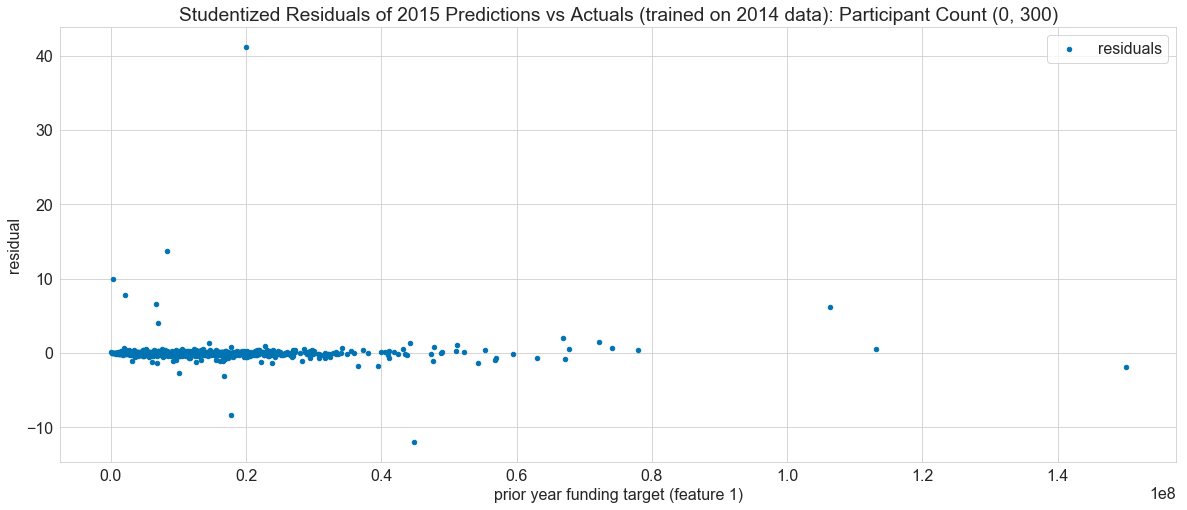

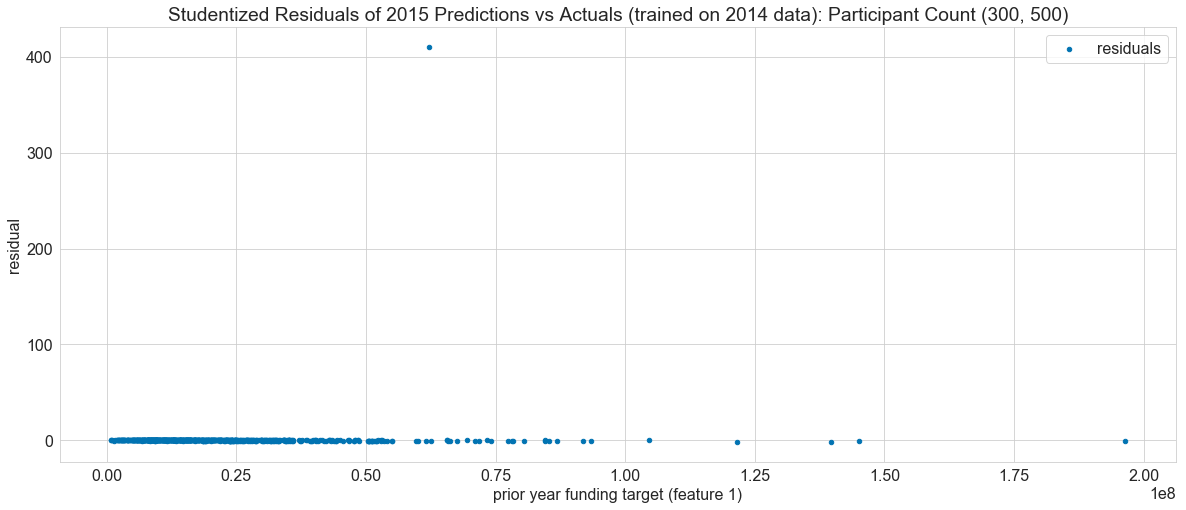

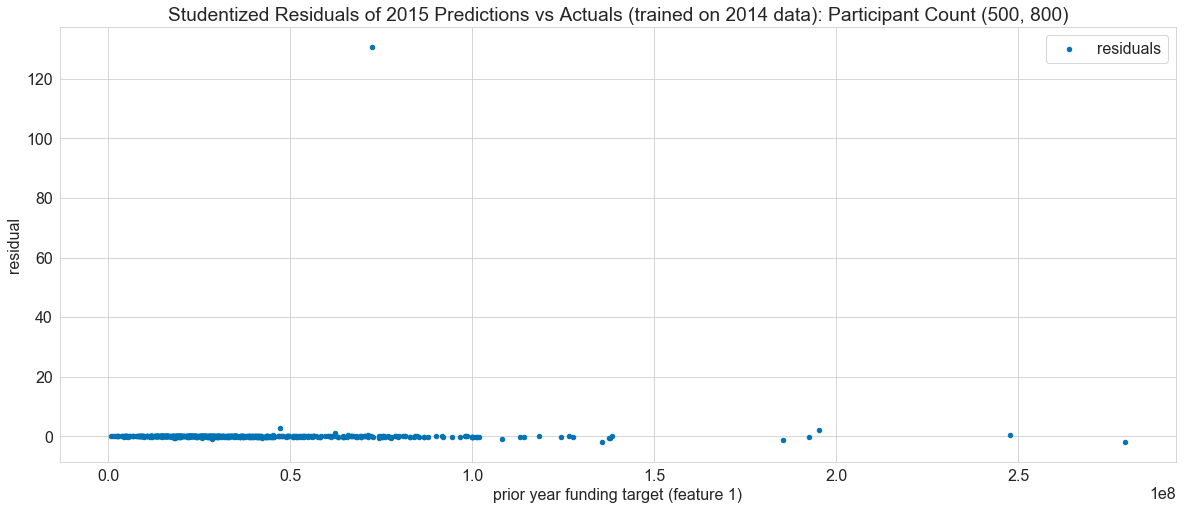

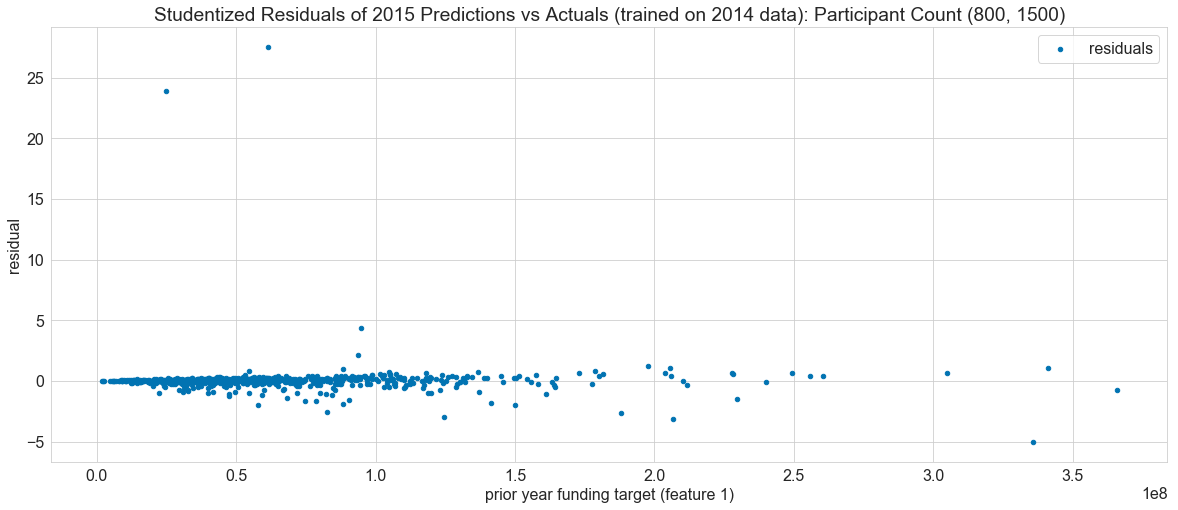

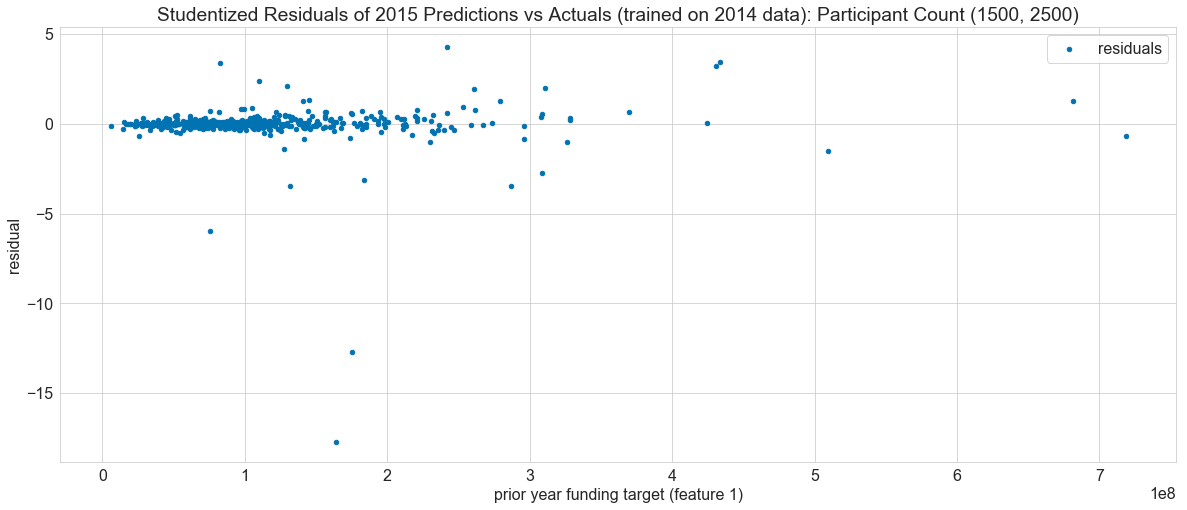

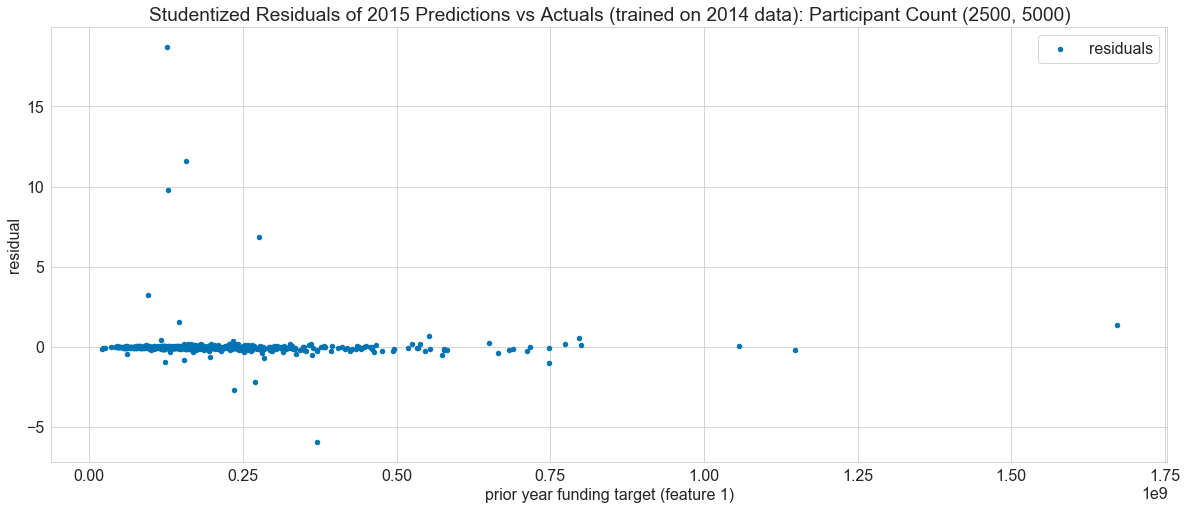

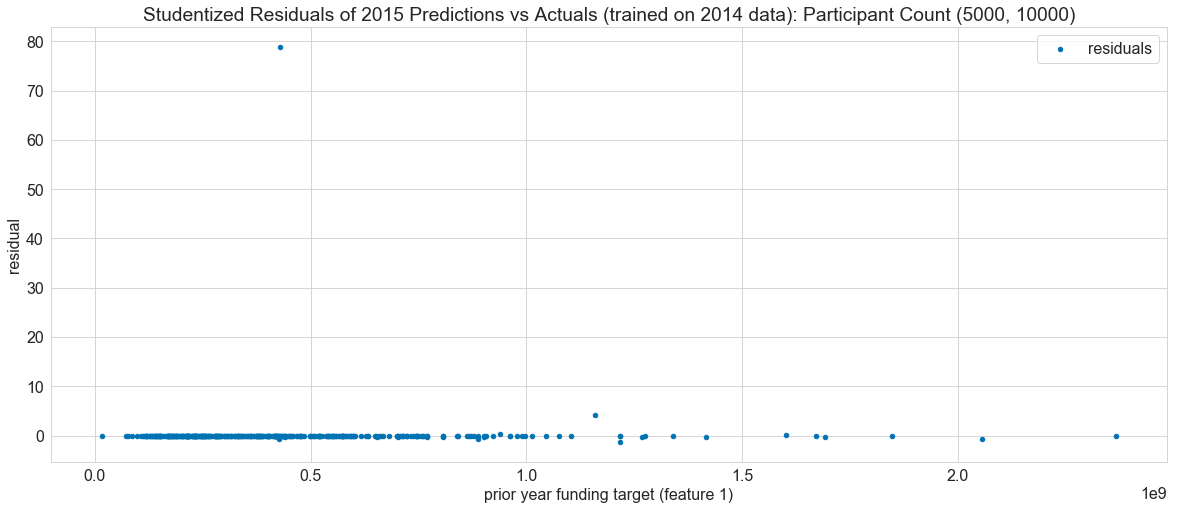

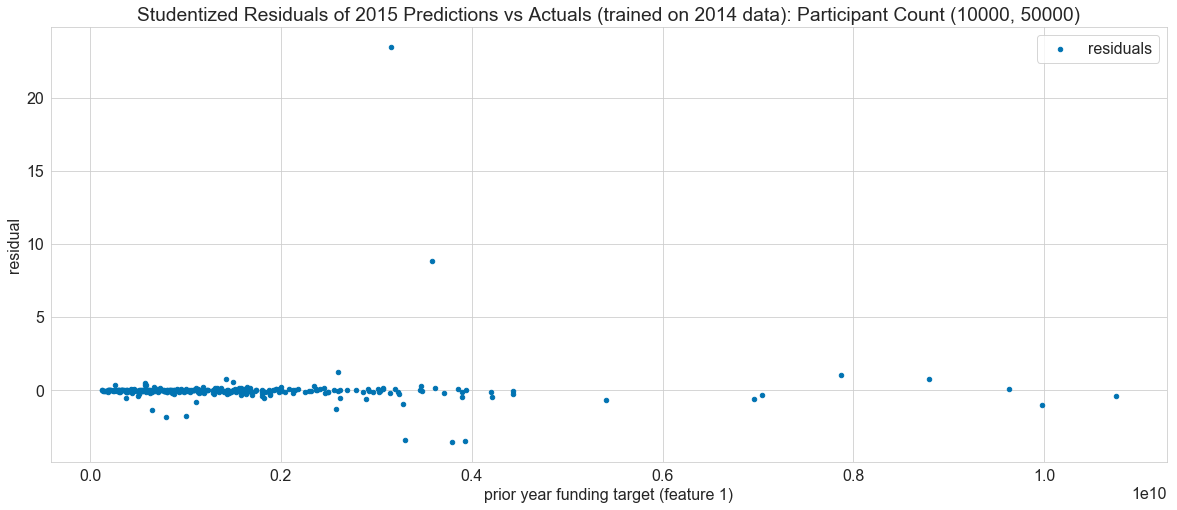

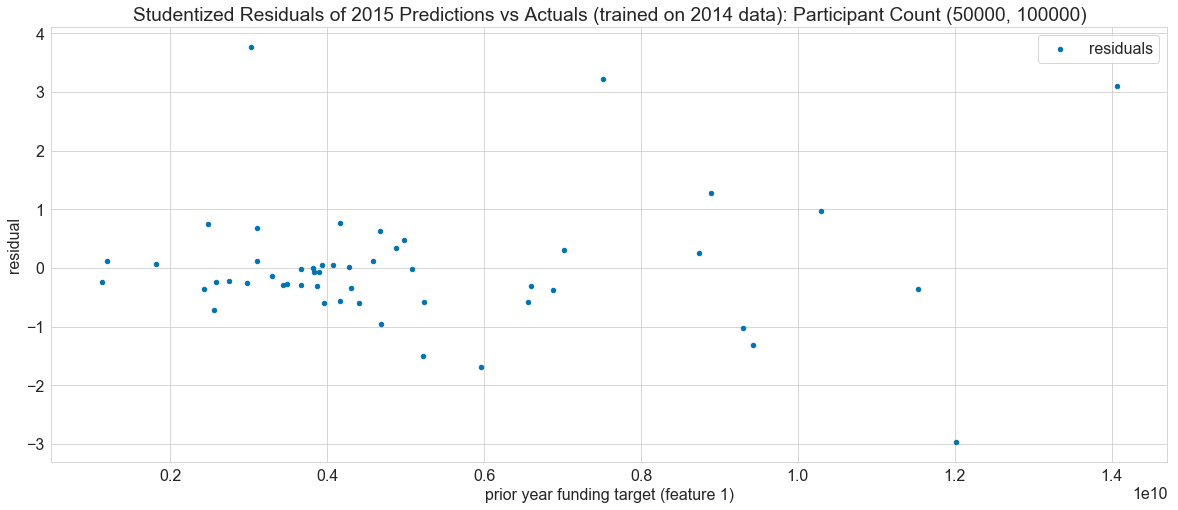

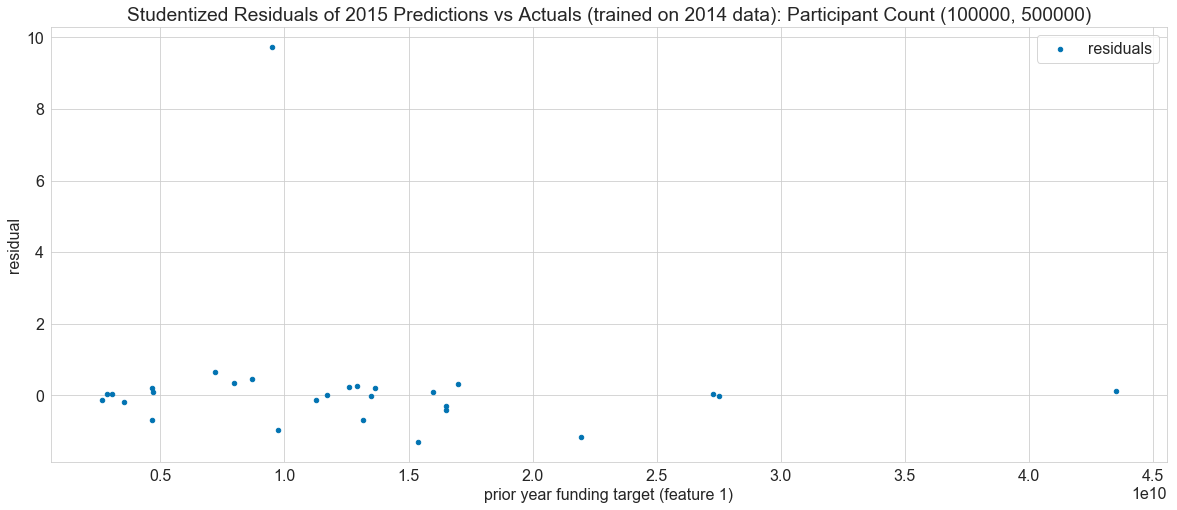

In [63]:
for i in partition_list:
    plt.figure(figsize=(20,8))
    X, y = partitioned_dict_of_df_14[i]
    xx = X['eir_ft']
    yy = studentized_resids_14[i]['student_resid']
    plt.scatter(xx, yy, s=20, label="residuals")
    plt.xlabel("prior year funding target (feature 1)")
    plt.ylabel("residual")
    plt.title("Studentized Residuals of {} Predictions vs Actuals (trained on {} data): Participant Count {}".format(2015, 2014, i))
    plt.legend()
    plt.show()

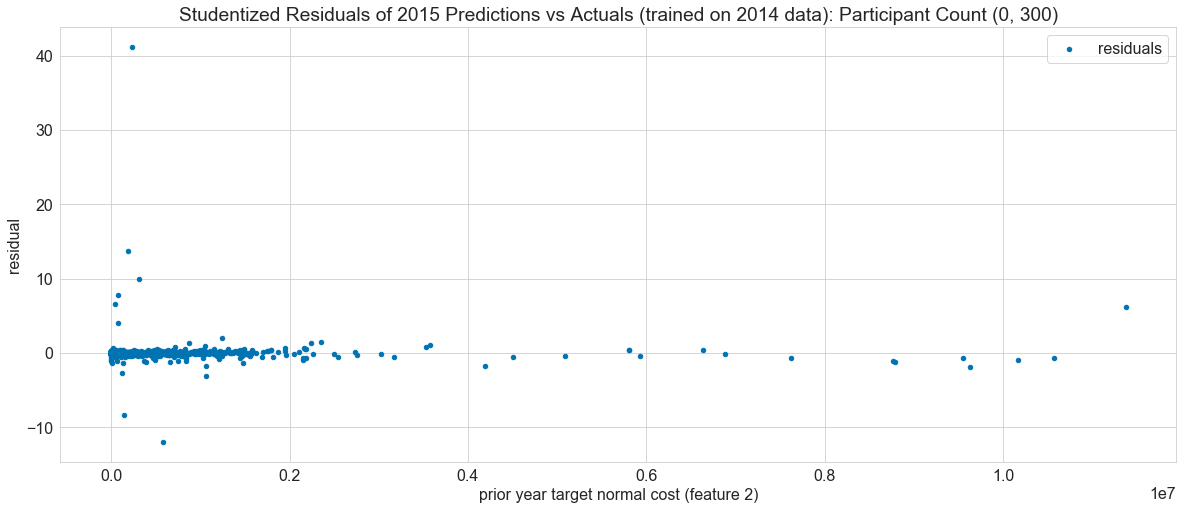

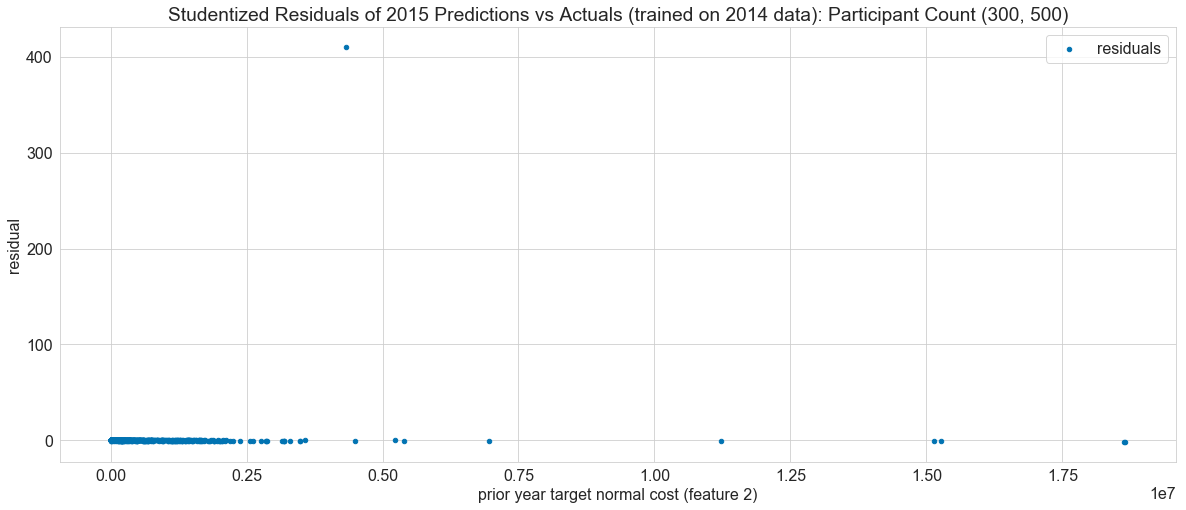

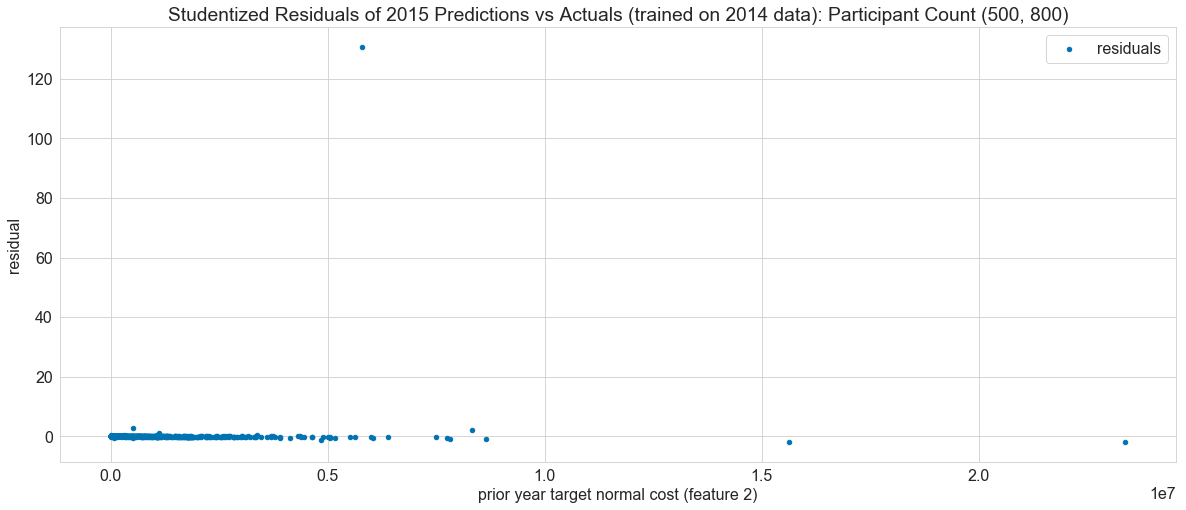

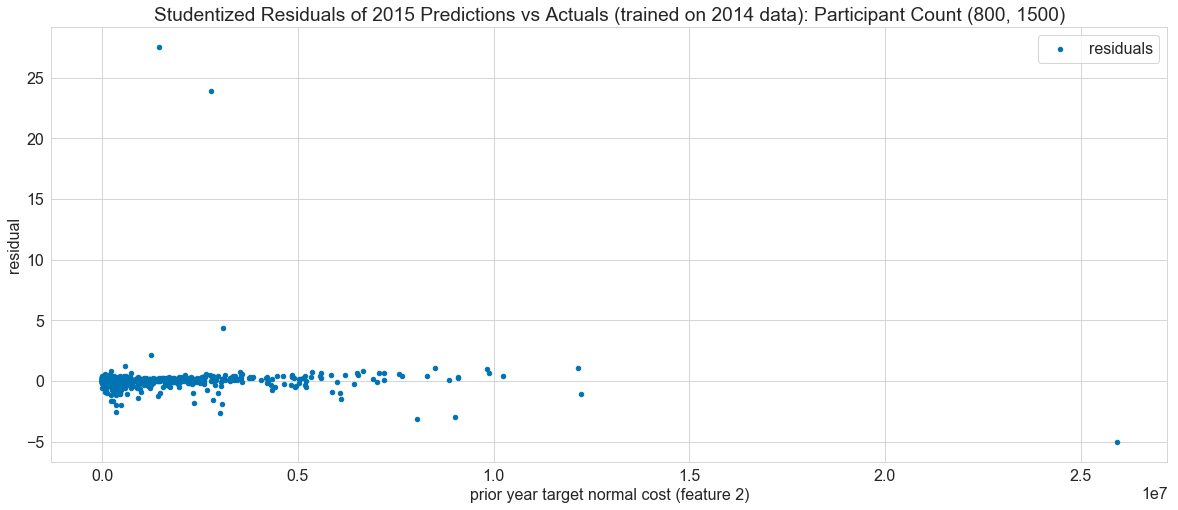

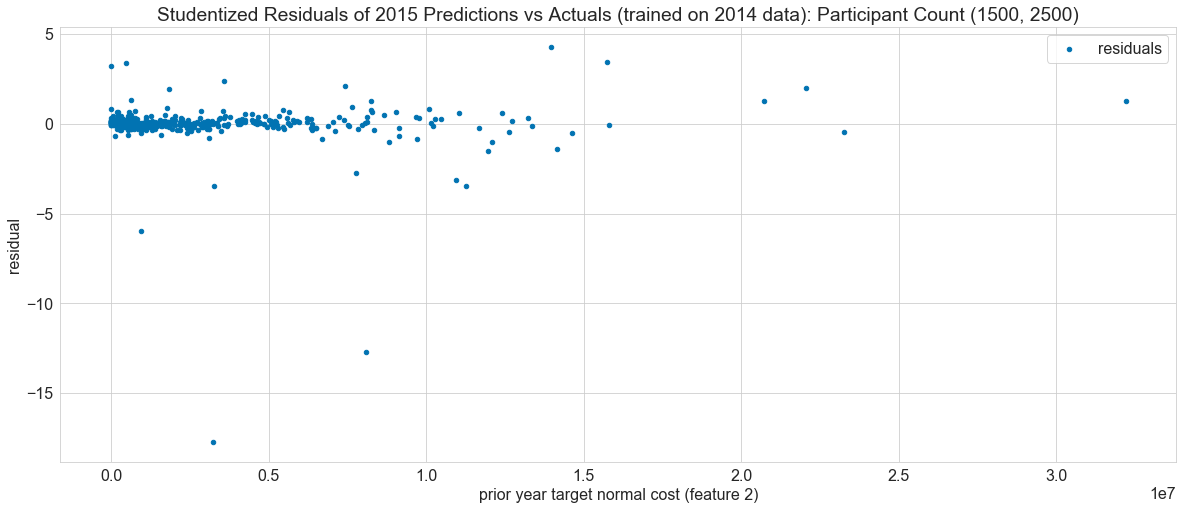

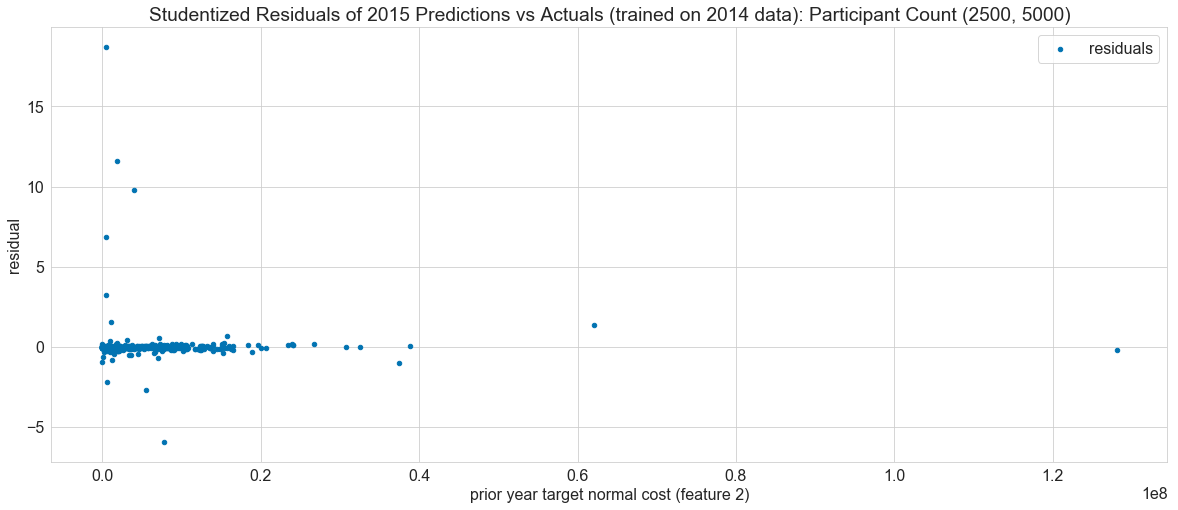

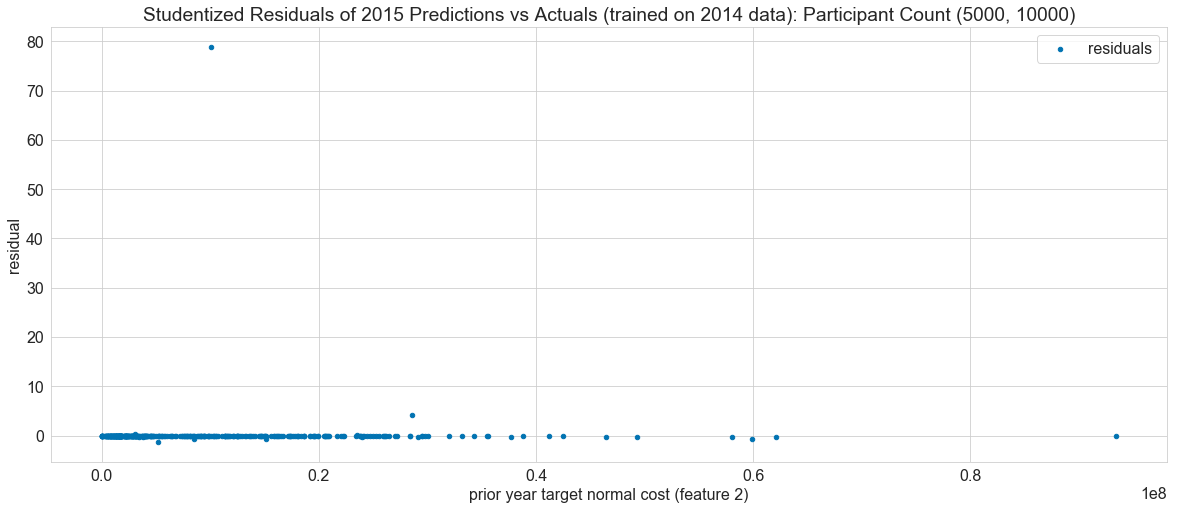

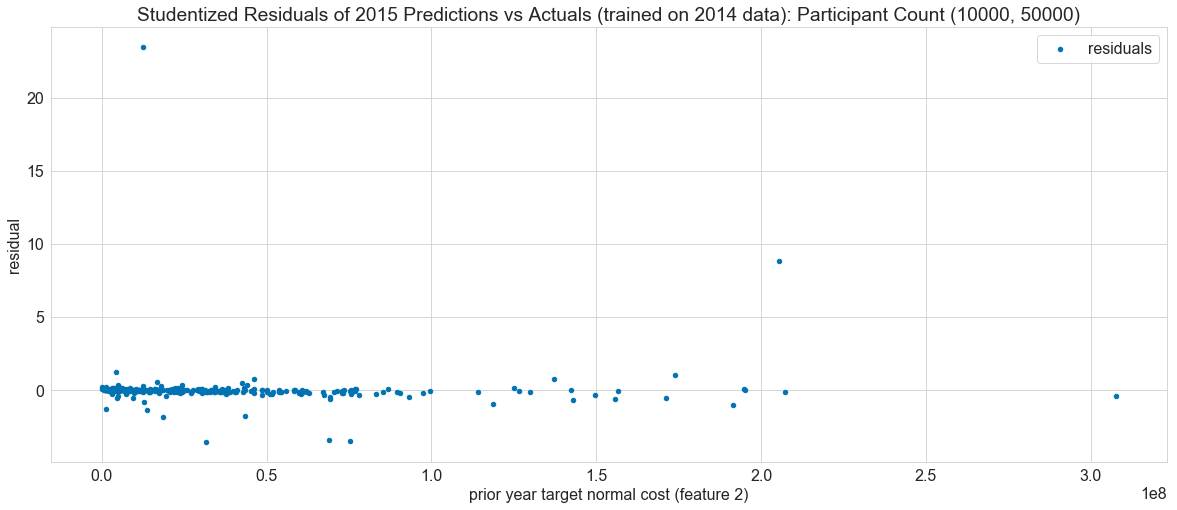

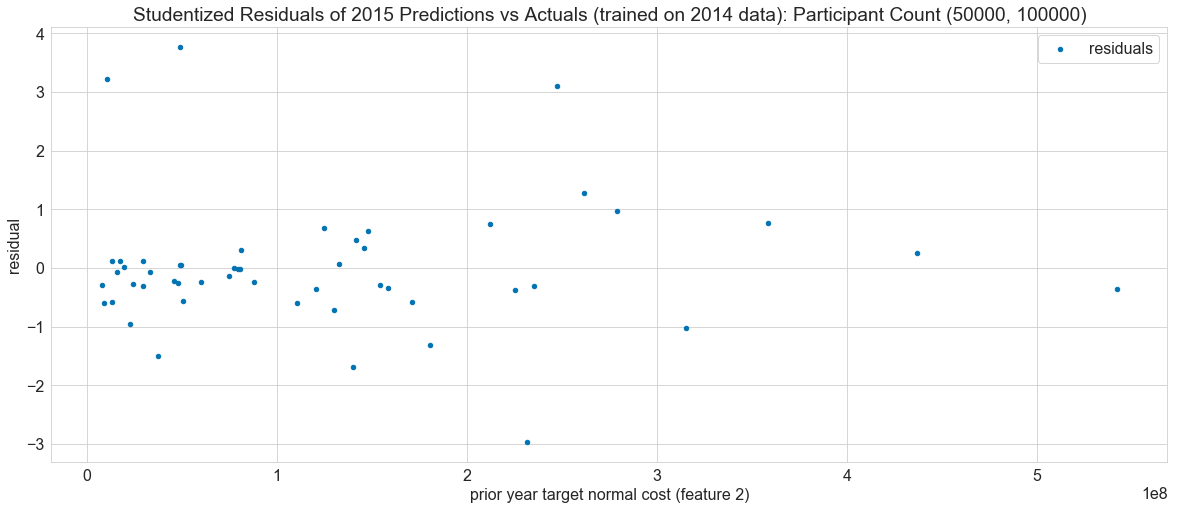

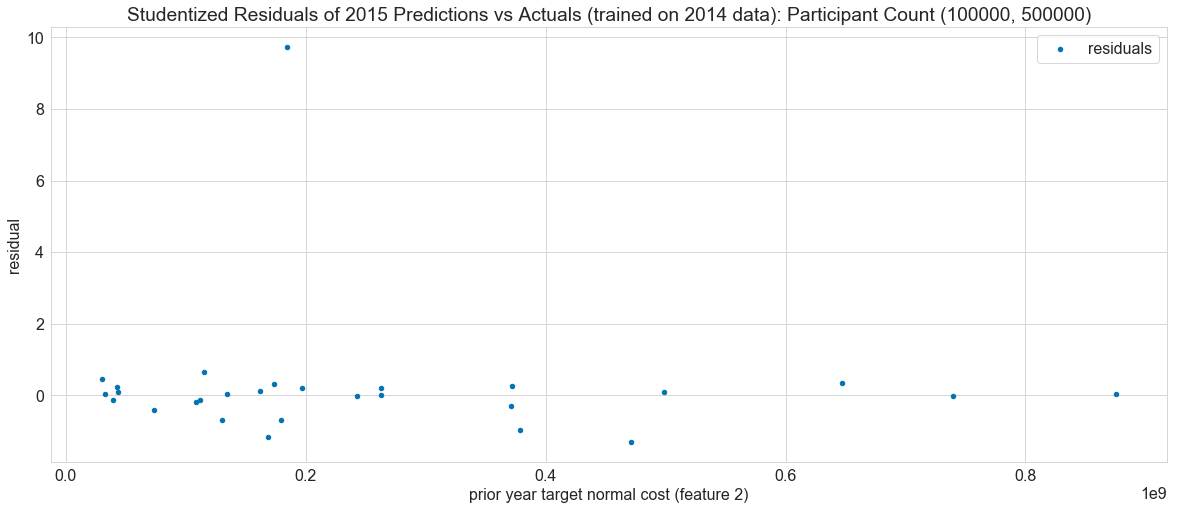

In [64]:
for i in partition_list:
    plt.figure(figsize=(20,8))
    X, y = partitioned_dict_of_df_14[i]
    xx = X['eir_tnc']
    yy = studentized_resids_14[i]['student_resid']
    plt.scatter(xx, yy, s=20, label="residuals")
    plt.xlabel("prior year target normal cost (feature 2)")
    plt.ylabel("residual")
    plt.title("Studentized Residuals of {} Predictions vs Actuals (trained on {} data): Participant Count {}".format(2015, 2014, i))
    plt.legend()
    plt.show()

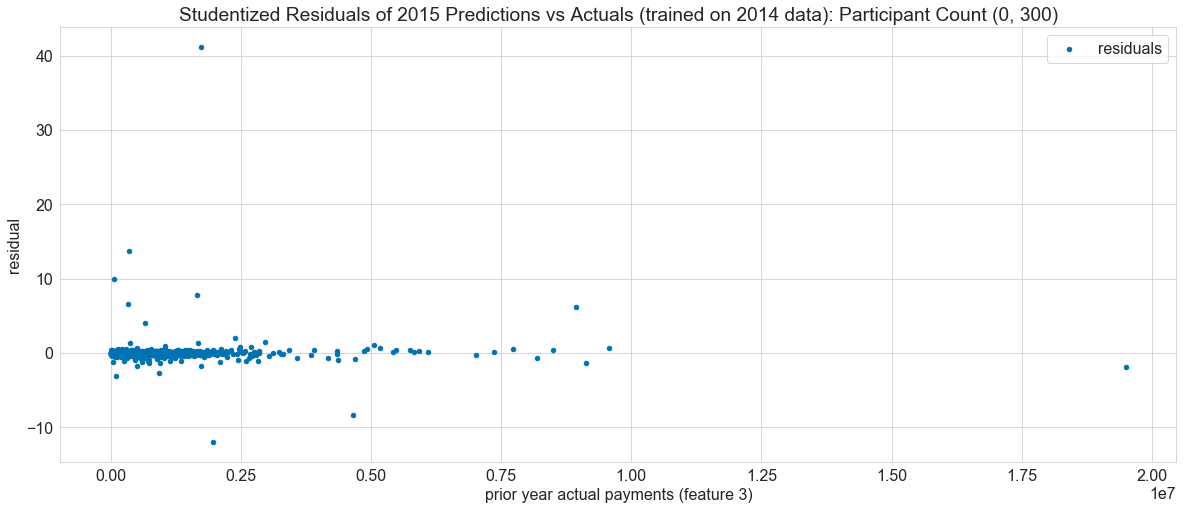

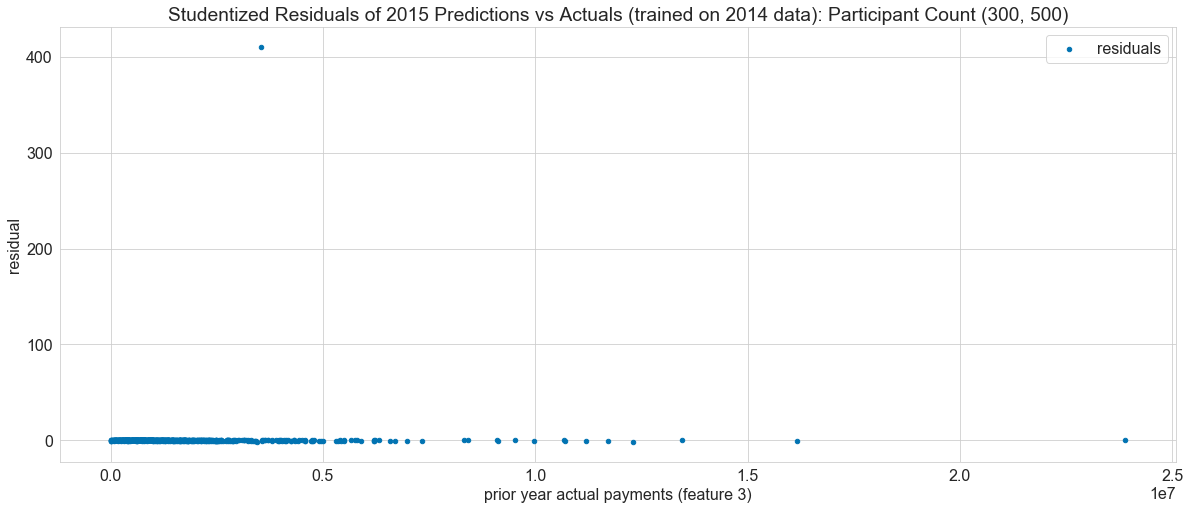

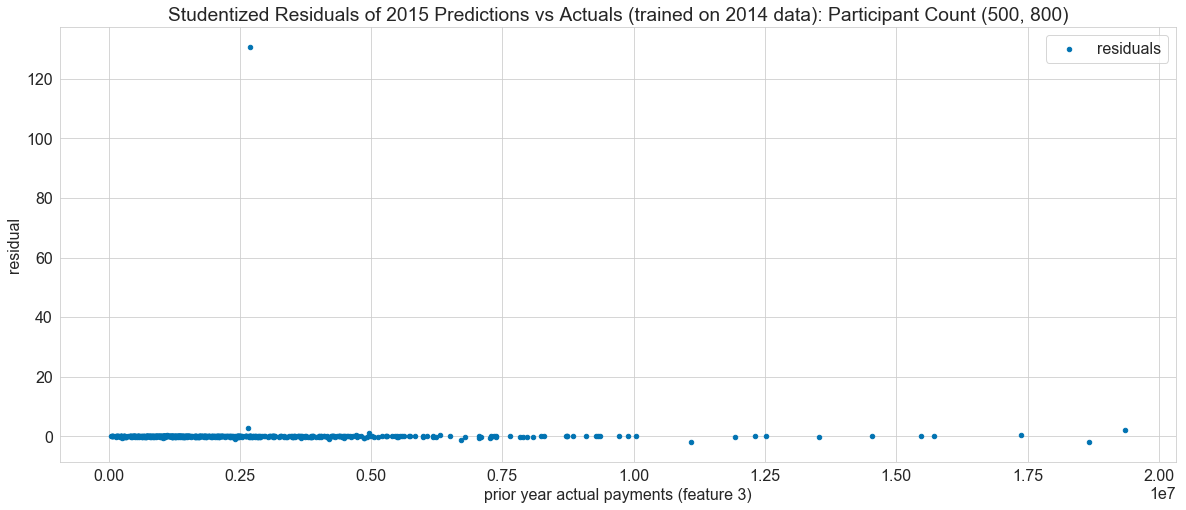

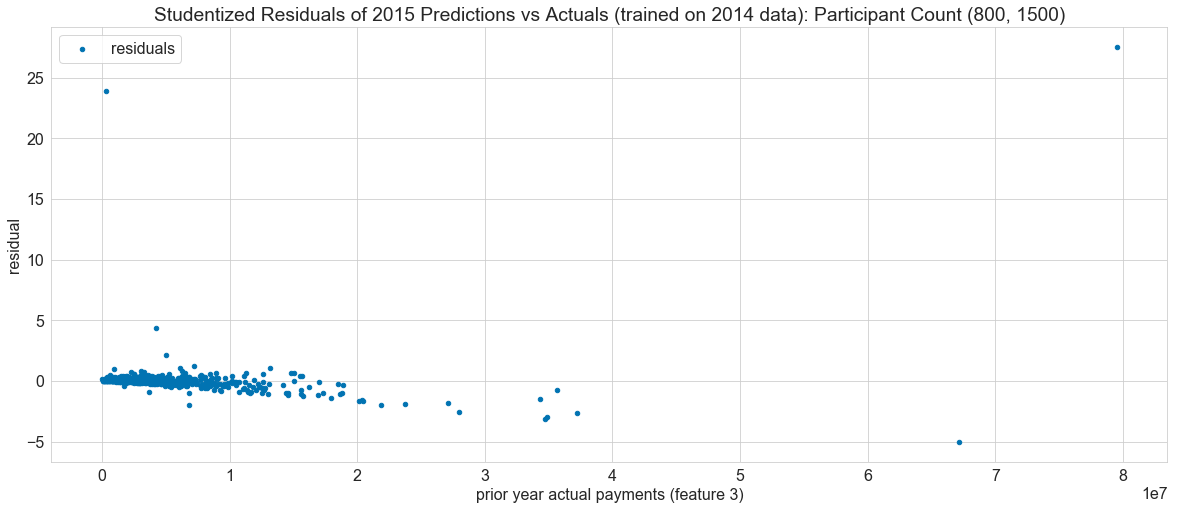

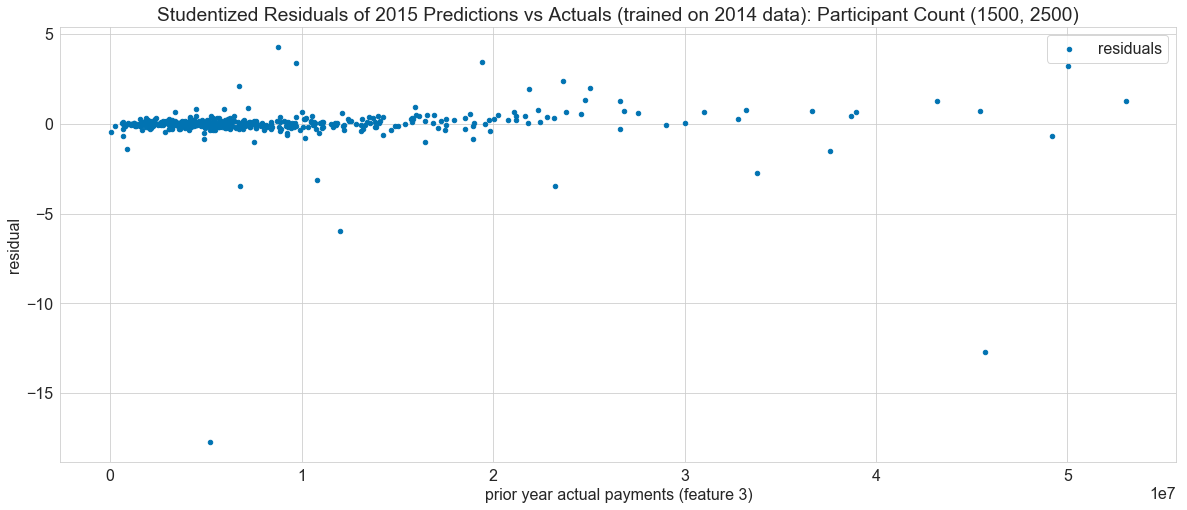

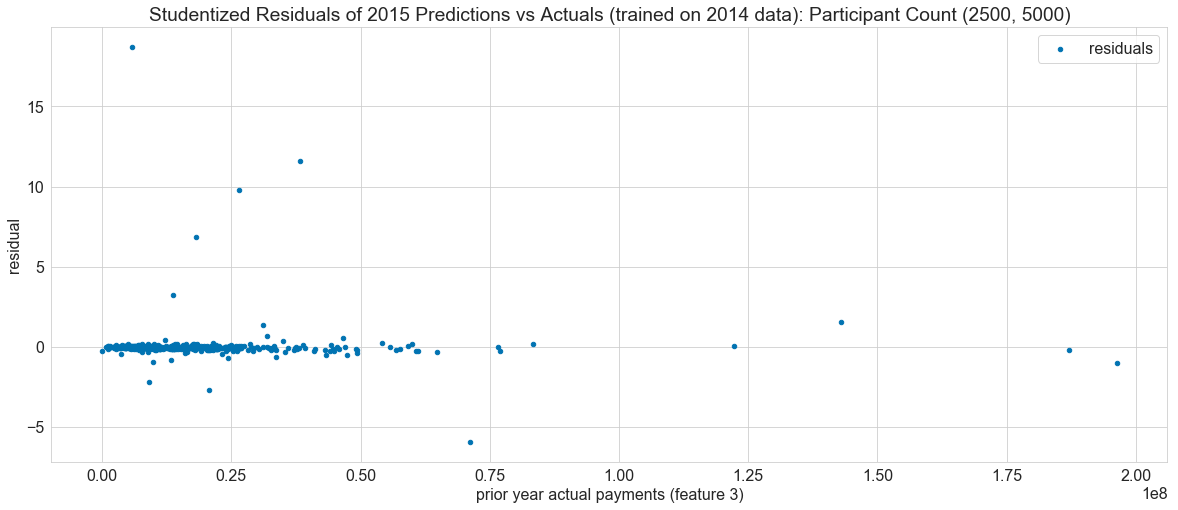

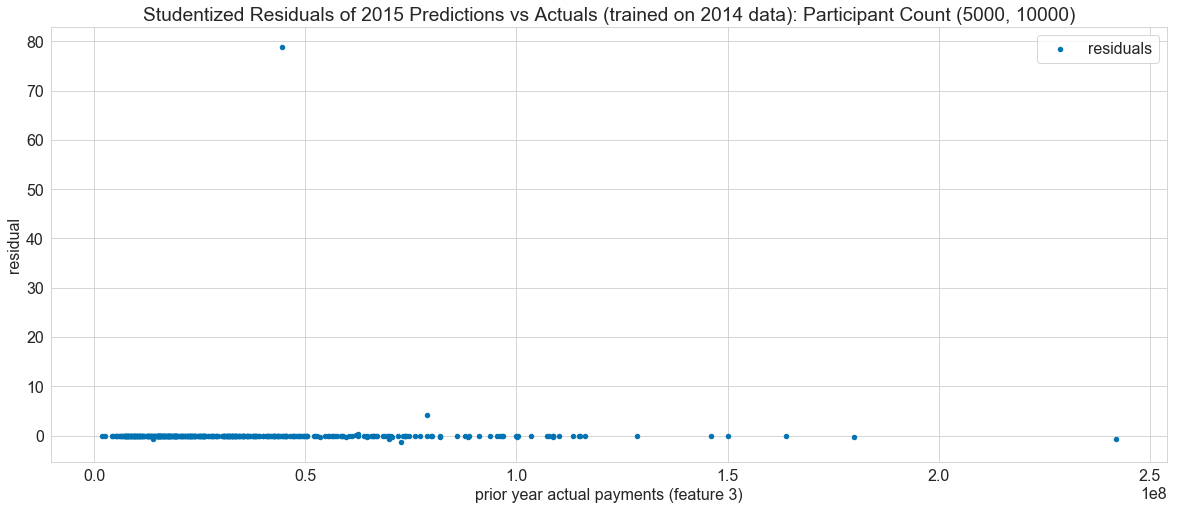

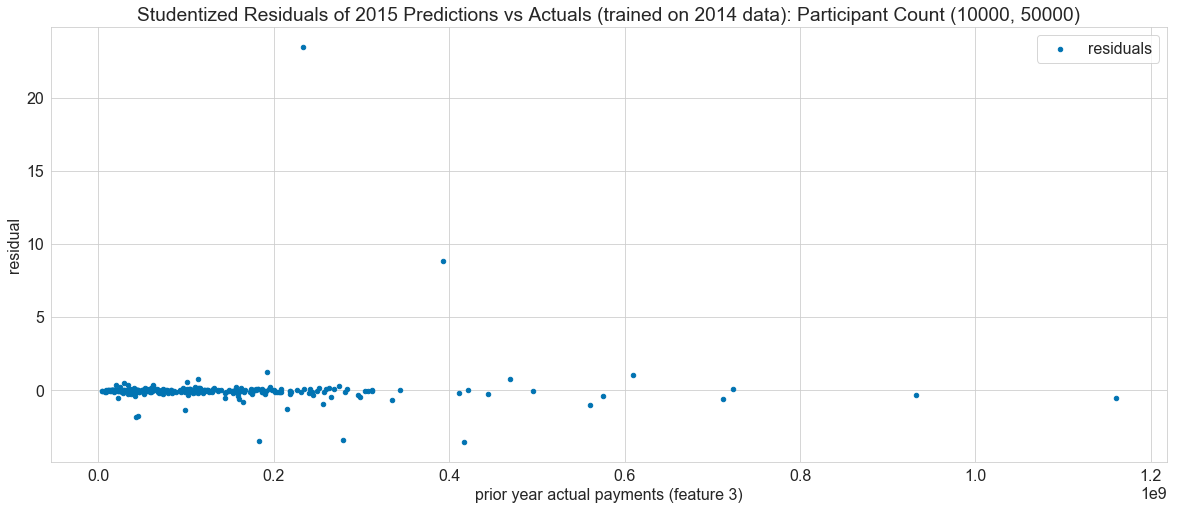

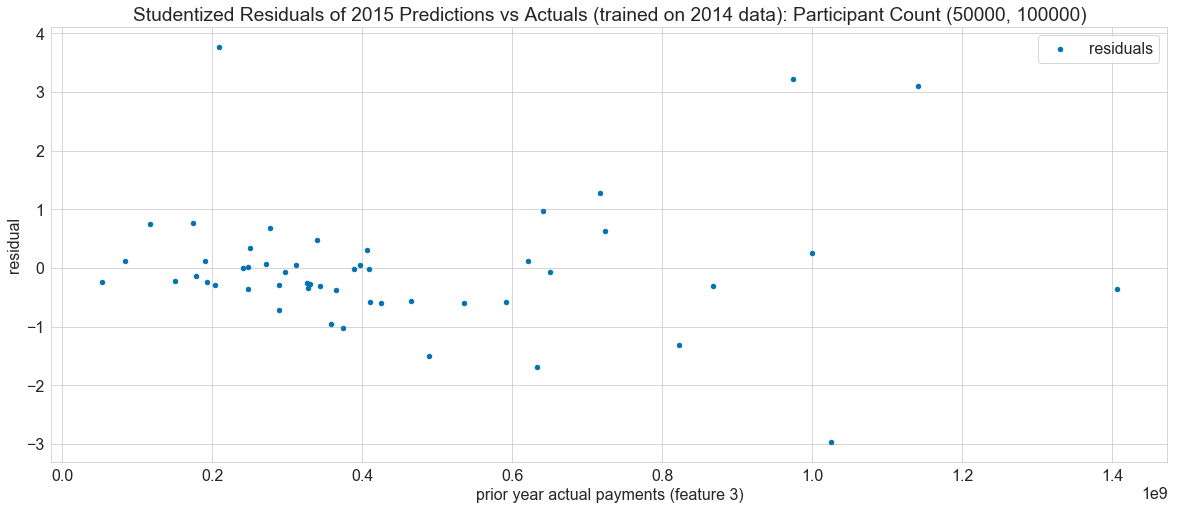

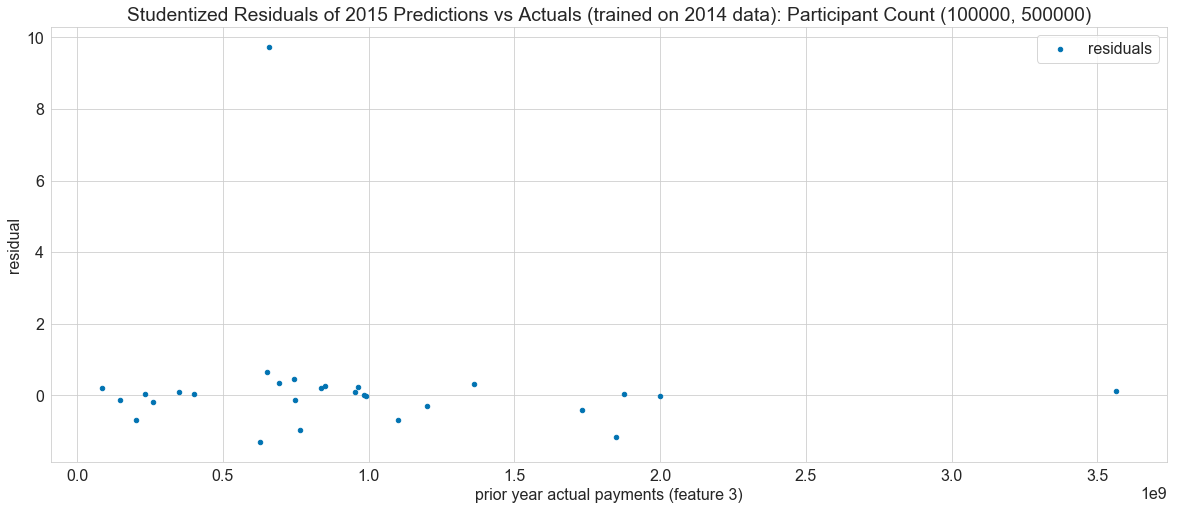

In [65]:
for i in partition_list:
    plt.figure(figsize=(20,8))
    X, y = partitioned_dict_of_df_14[i]
    xx = X['eir_pmt']
    yy = studentized_resids_14[i]['student_resid']
    plt.scatter(xx, yy, s=20, label="residuals")
    plt.xlabel("prior year actual payments (feature 3)")
    plt.ylabel("residual")
    plt.title("Studentized Residuals of {} Predictions vs Actuals (trained on {} data): Participant Count {}".format(2015, 2014, i))
    plt.legend()
    plt.show()

<h1>Create dictionary of linear models (WLS) fitted on 2014 partitioned data</h1>

In [6]:
model_dict_wls = {}
for i in partition_list:
    X, y = partitioned_dict_of_df_14[i]
    model_dict_wls[i] = sm.WLS(y, X, hasconst=False).fit()
    print(i, model_dict_wls[i].summary())

(0, 300)                             WLS Regression Results                            
Dep. Variable:         fndng_tgt_2015   R-squared:                       0.987
Model:                            WLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 3.797e+04
Date:                Thu, 06 Dec 2018   Prob (F-statistic):               0.00
Time:                        08:57:43   Log-Likelihood:                -23676.
No. Observations:                1500   AIC:                         4.736e+04
Df Residuals:                    1497   BIC:                         4.737e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
eir_ft         1.0185      0.006    176.963

<h1>Test on 2015 data:</h1>
<ul>
    <li>Get data
    <li>create dictionary of predictions
    <li>graph actual values vs predictions
    </ul>

In [7]:
partitioned_dict_of_df_15 = partition_feats_by_ptp_cnt(2015)

In [11]:
predict_dict_15 = {}
studentized_resids_15 = {}
predict_dict_wls_15 = {}
for i in partition_list:
    X, y = partitioned_dict_of_df_15[i]
    predict_dict_15[i] = model_dict[i].predict(X)
    predict_dict_wls_15[i] = model_dict_wls[i].predict(X)

In [15]:
total_ft = {}
num_plans = {}
total_pred = {}
total_pred_w = {}
for i in partition_list:
    total_ft[i] = np.sum(partitioned_dict_of_df_15[i][1])
    total_pred[i] = np.sum(predict_dict_15[i])
    total_pred_w[i] = np.sum(predict_dict_wls_15[i])
    num_plans[i] = len(partitioned_dict_of_df_15[i][0])

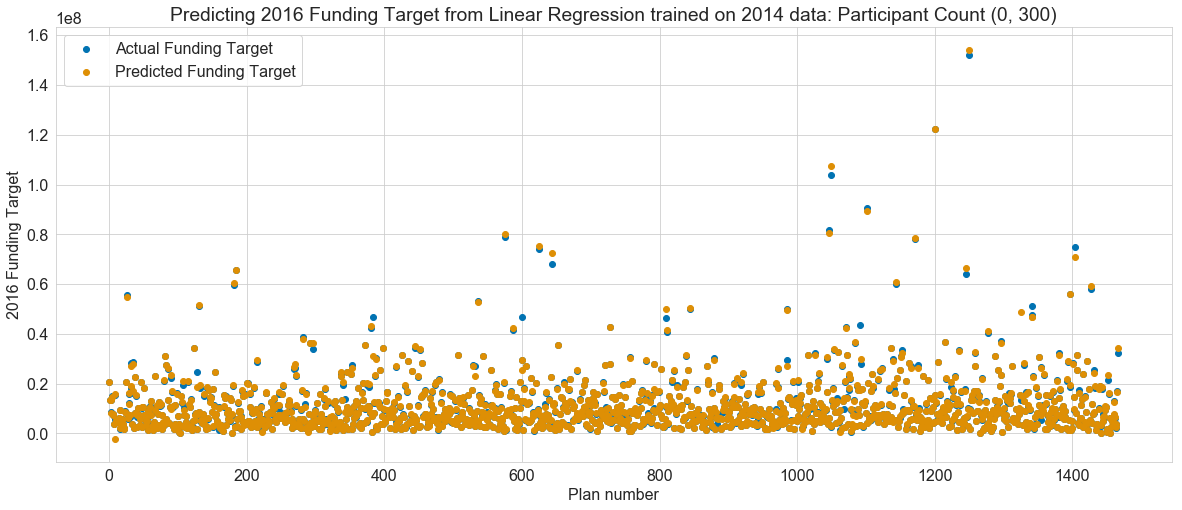

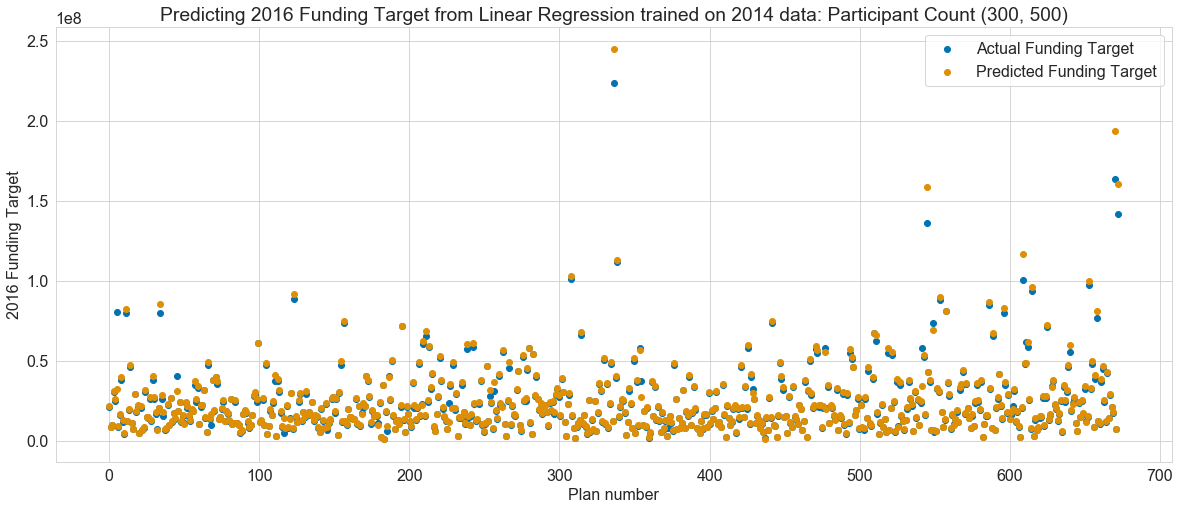

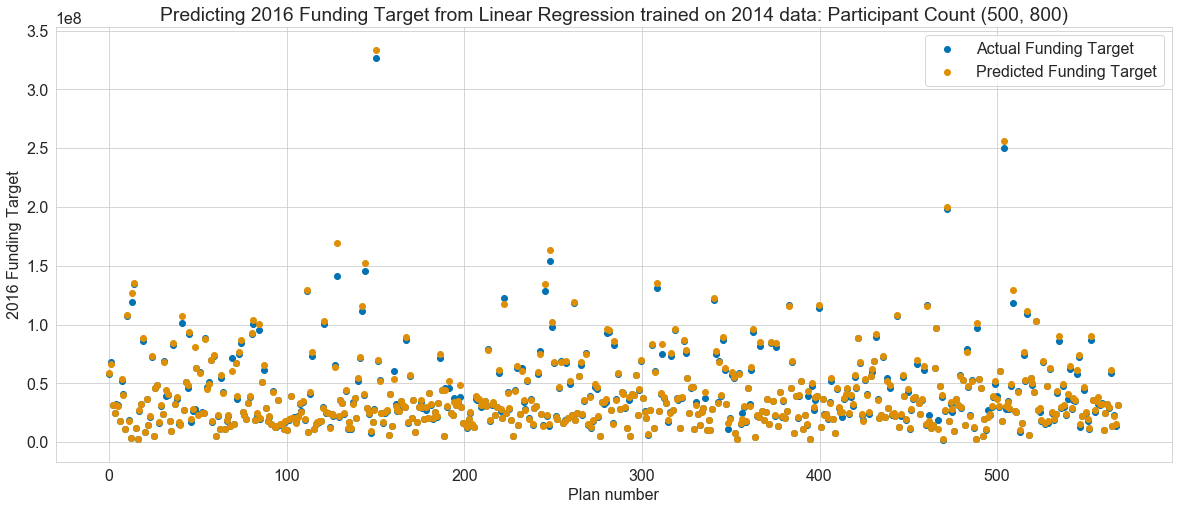

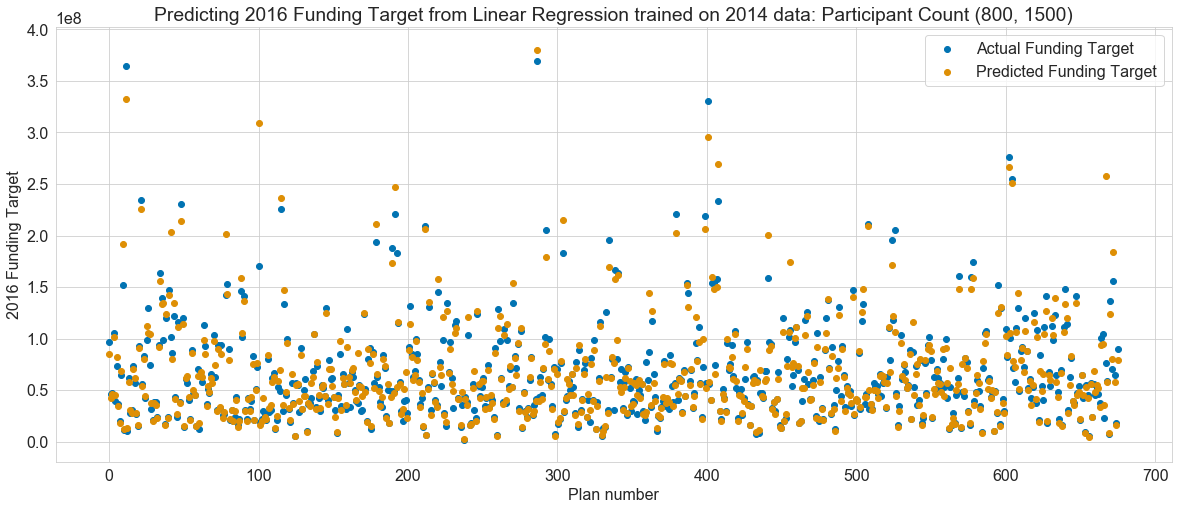

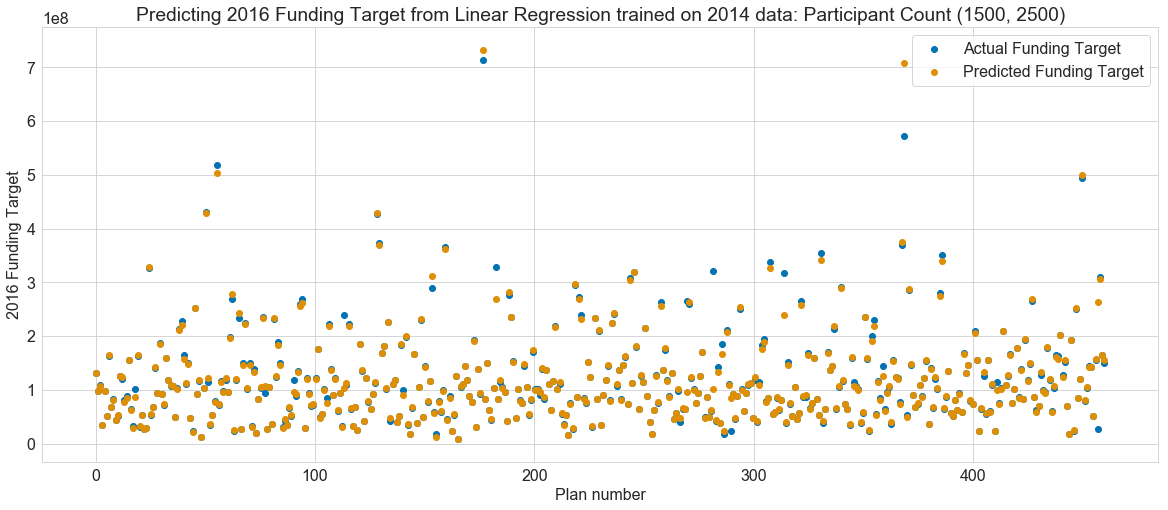

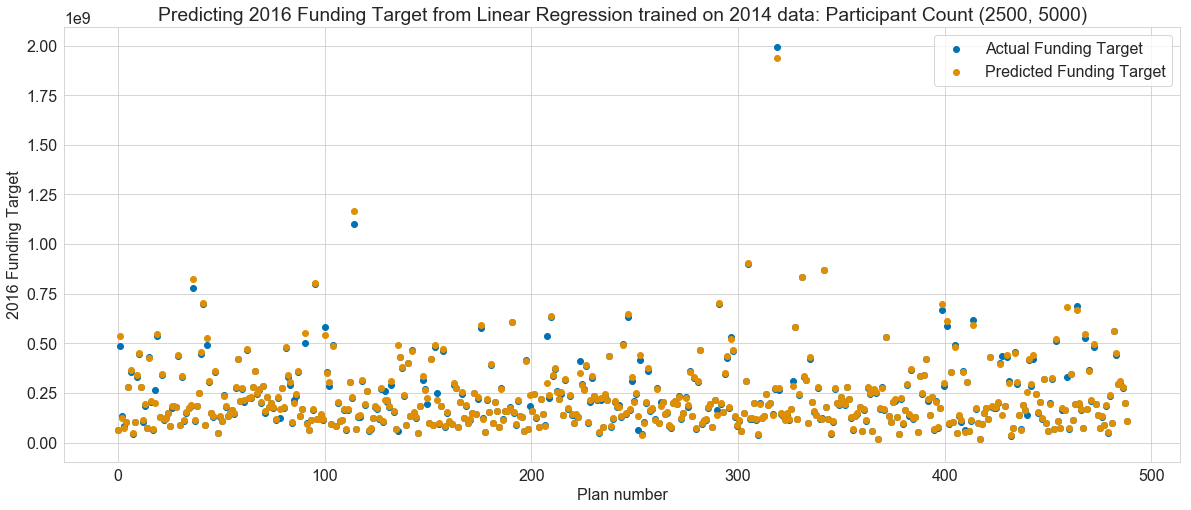

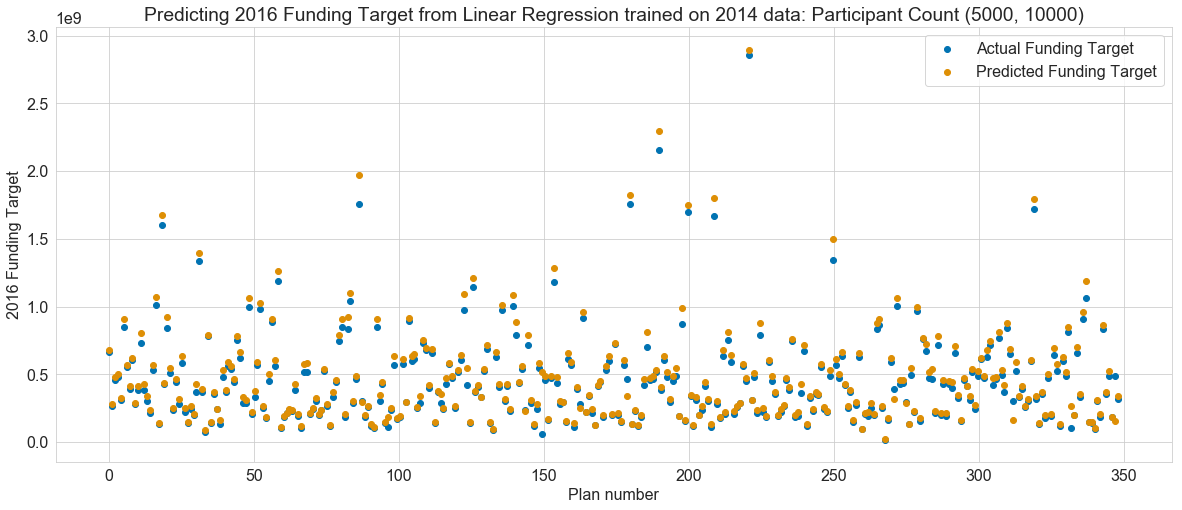

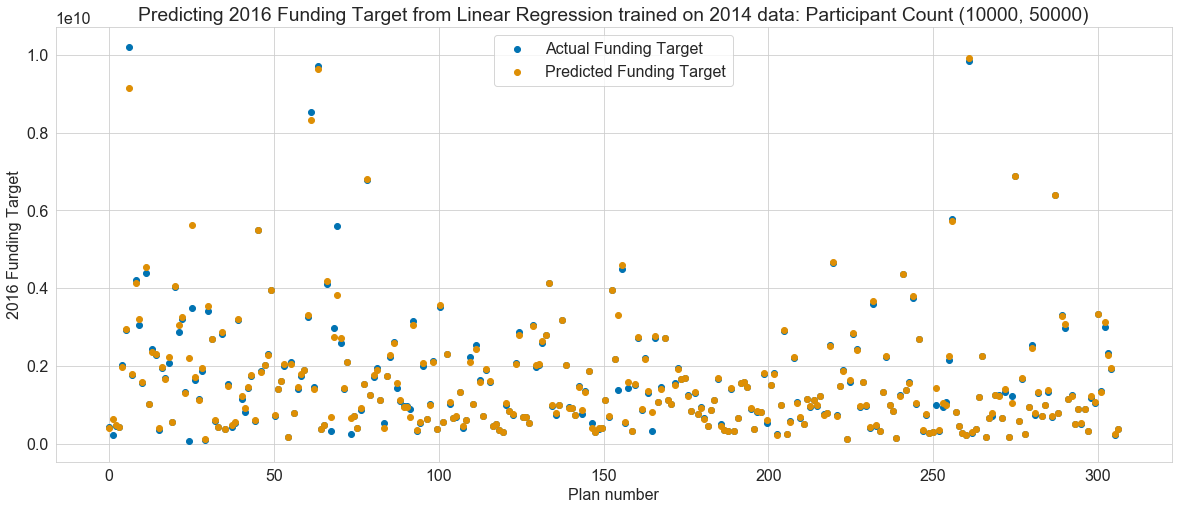

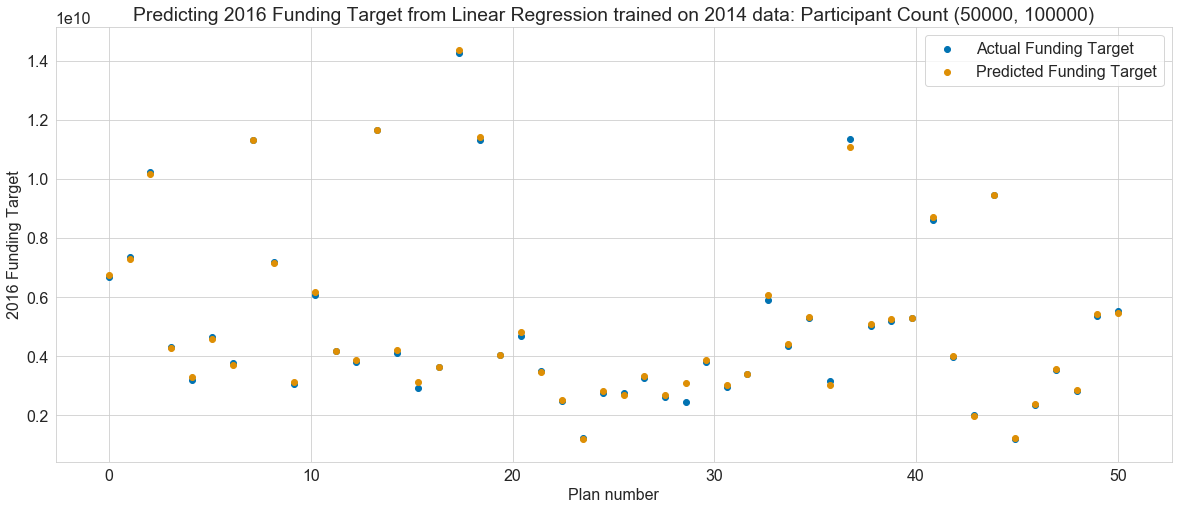

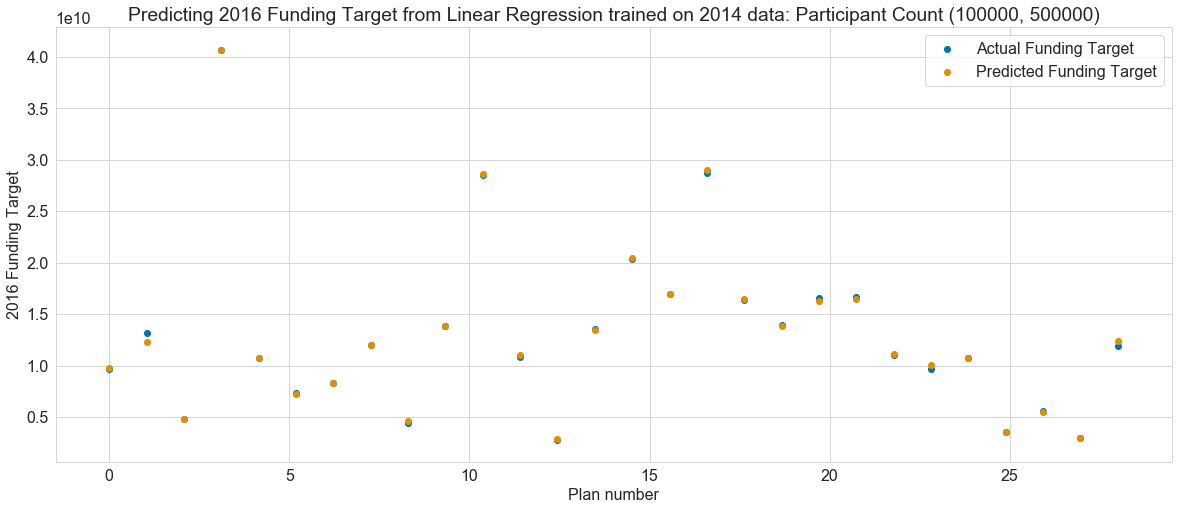

In [41]:
resids_15 = {}
for i in partition_list:
    y_true = partitioned_dict_of_df_15[i][1]
    y_pred = predict_dict_15[i]
    resids_15[i] = y_true - y_pred
    plot_results(y_true, y_pred, i, 2016, 2014)

<h3>Plot residuals as funciton of prior year funding target</h3>

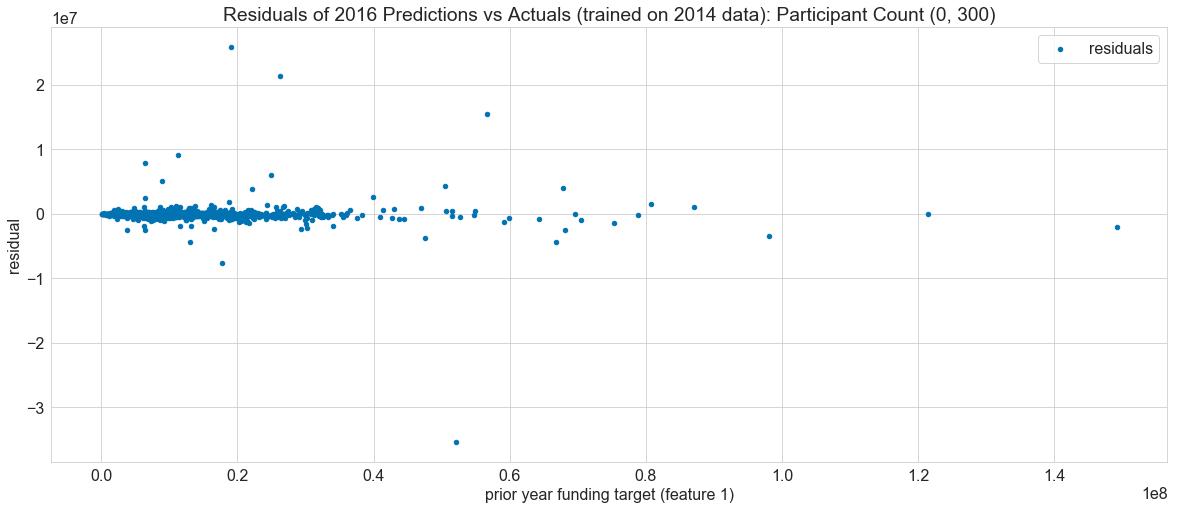

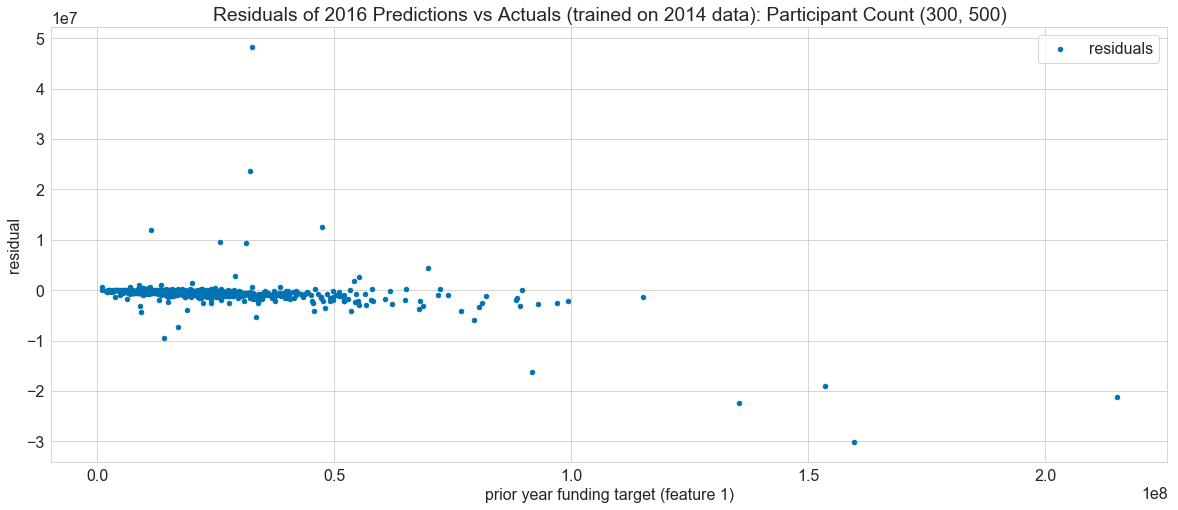

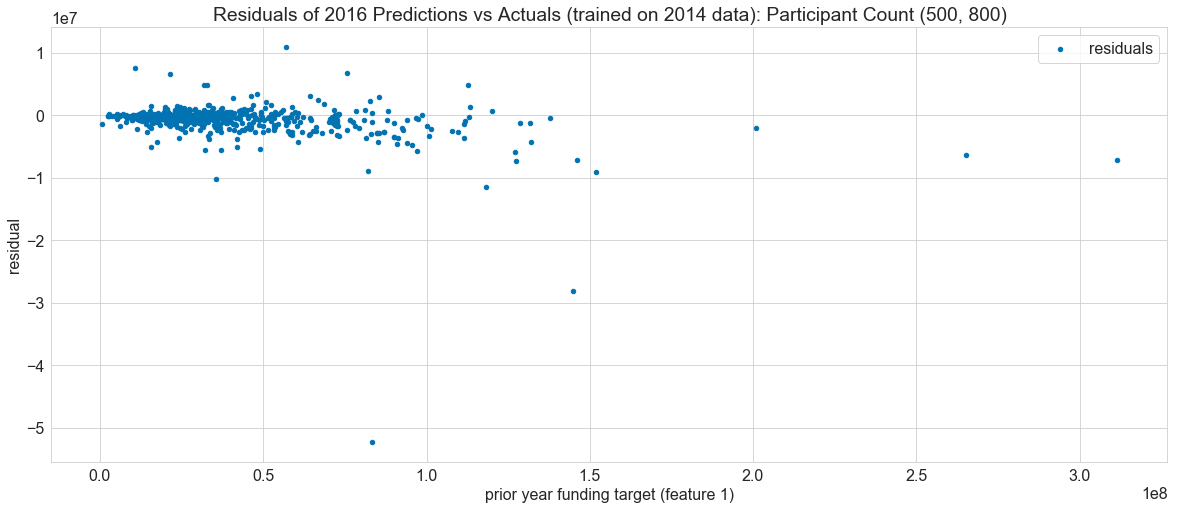

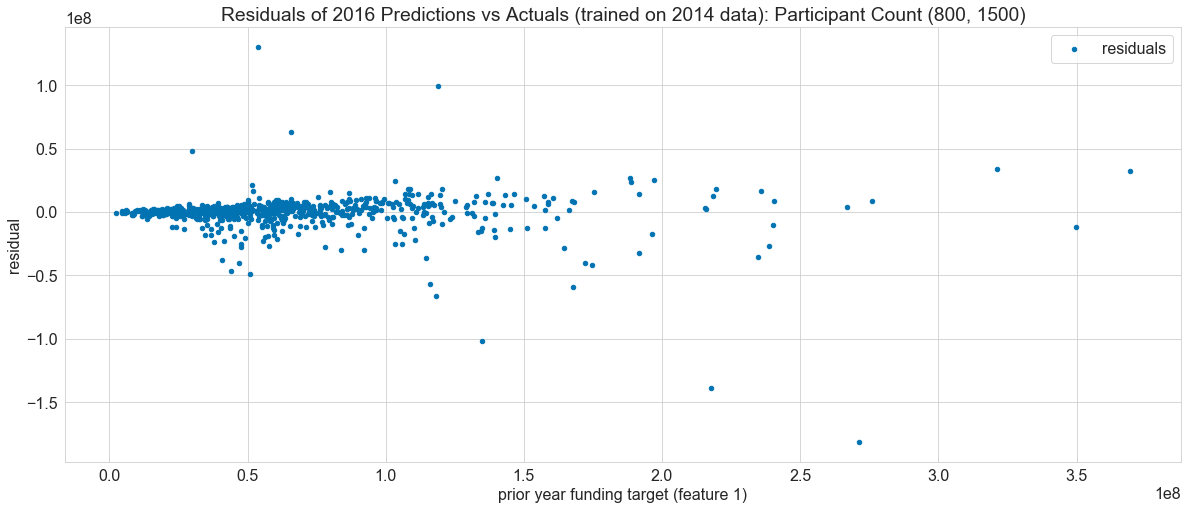

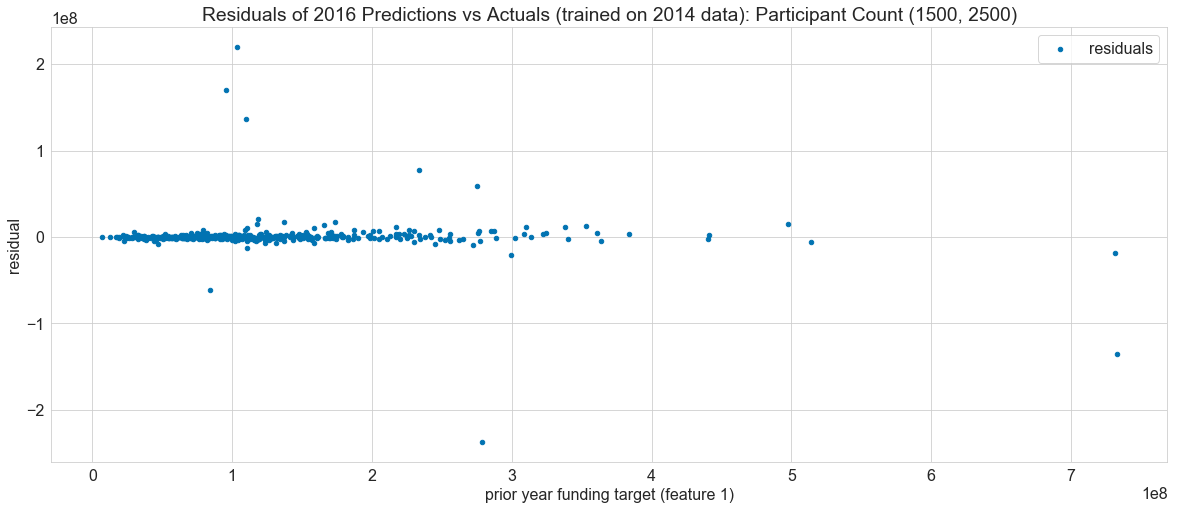

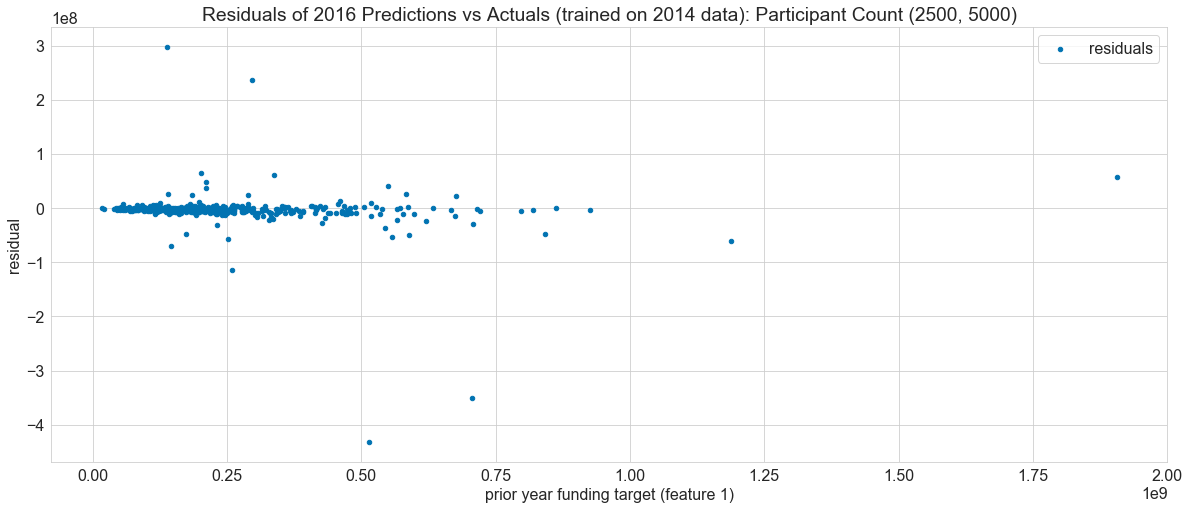

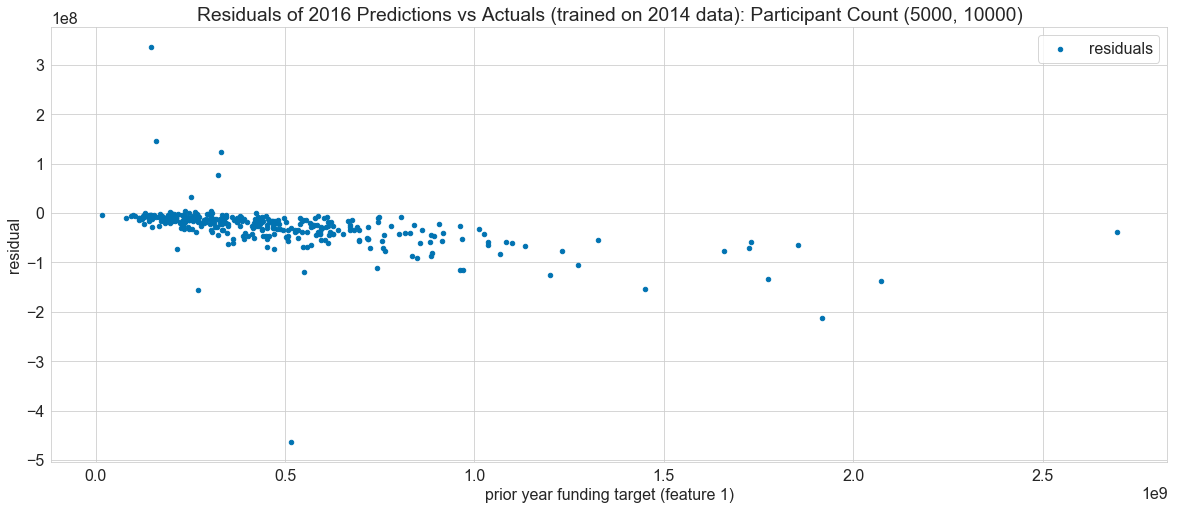

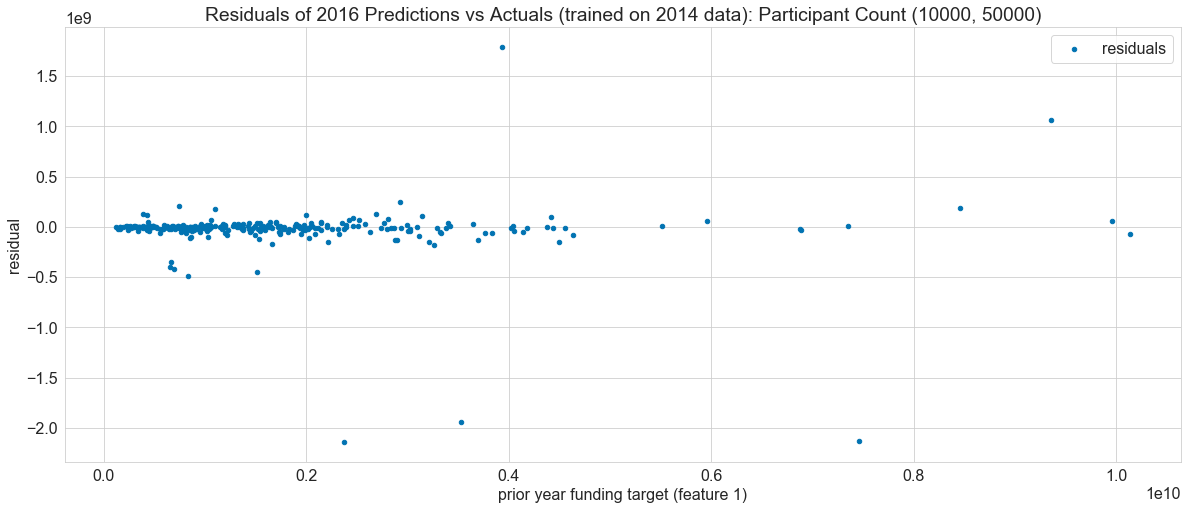

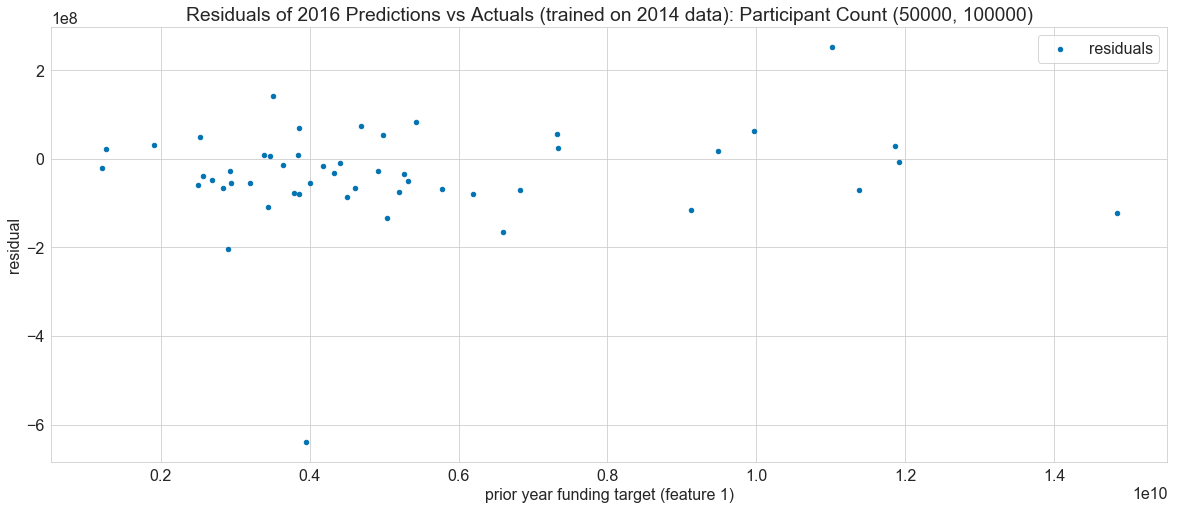

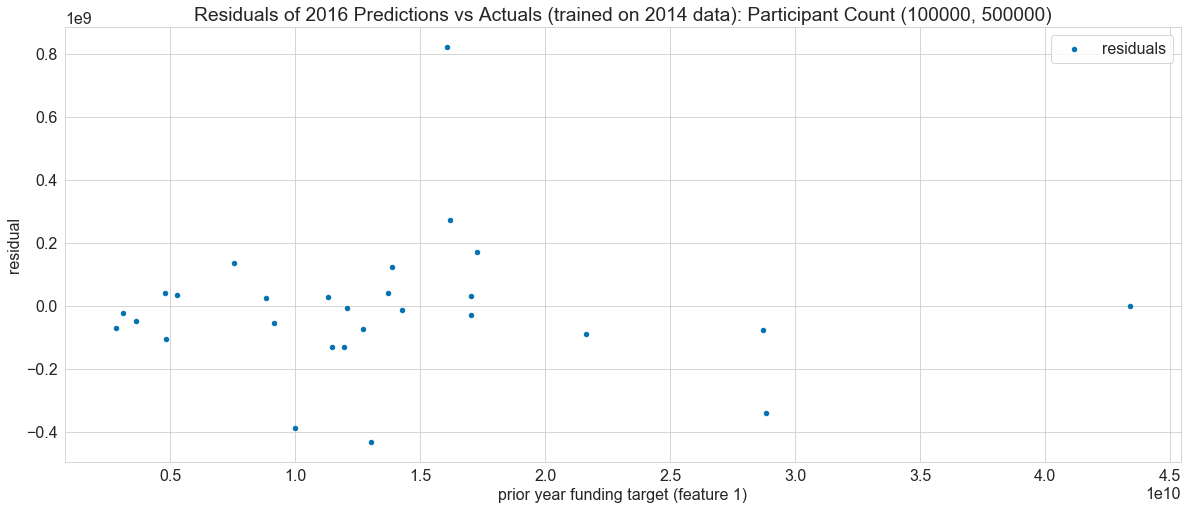

In [62]:
for i in partition_list:
    plt.figure(figsize=(20,8))
    sns.set_palette("colorblind")
    X, y = partitioned_dict_of_df_15[i]
    xx = X['eir_ft']
    yy = resids_15[i]
    plt.scatter(xx, yy, s=20, label="residuals")
    plt.xlabel("prior year funding target (feature 1)")
    plt.ylabel("residual")
    plt.title("Residuals of {} Predictions vs Actuals (trained on {} data): Participant Count {}".format(2016, 2014, i))
    plt.legend()
    plt.show()

<h3>Plot residuals as funciton of prior year NC</h3>

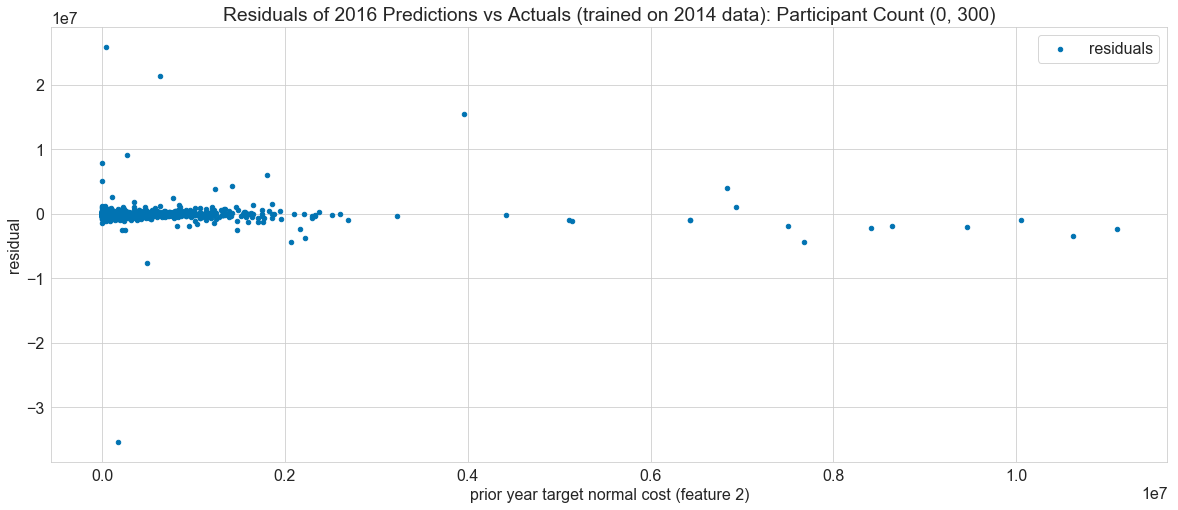

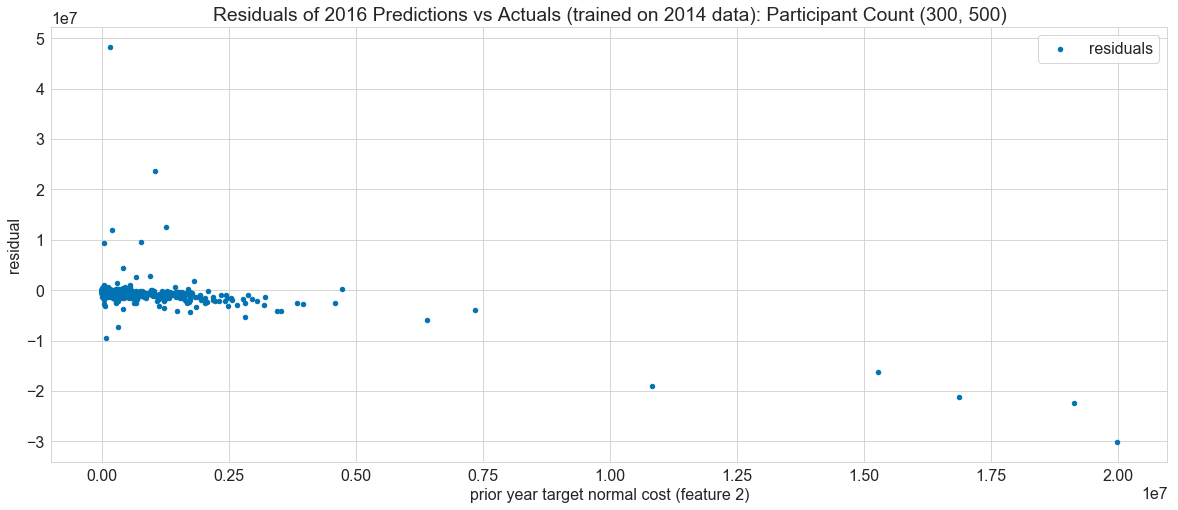

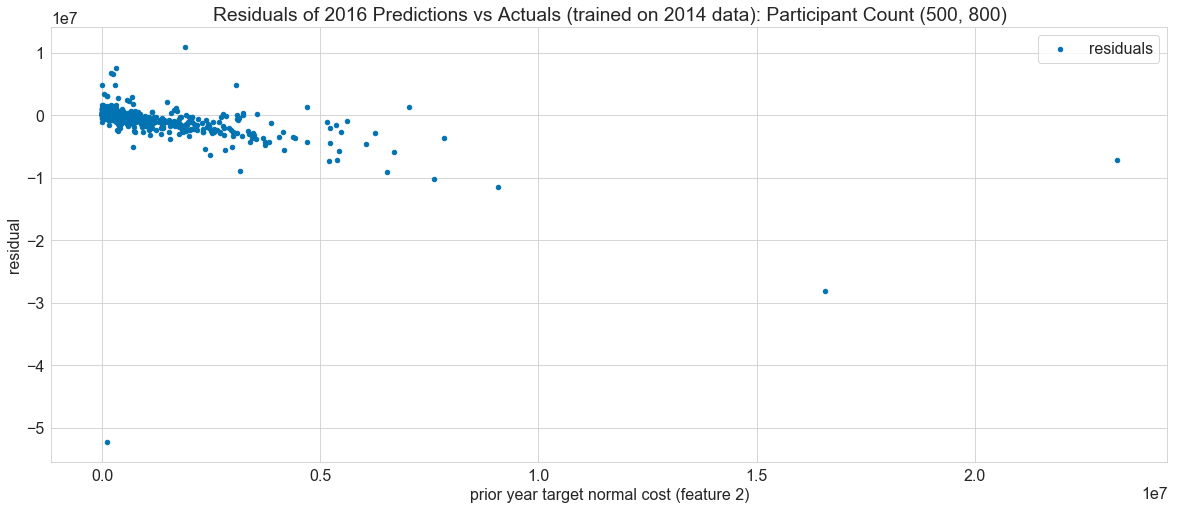

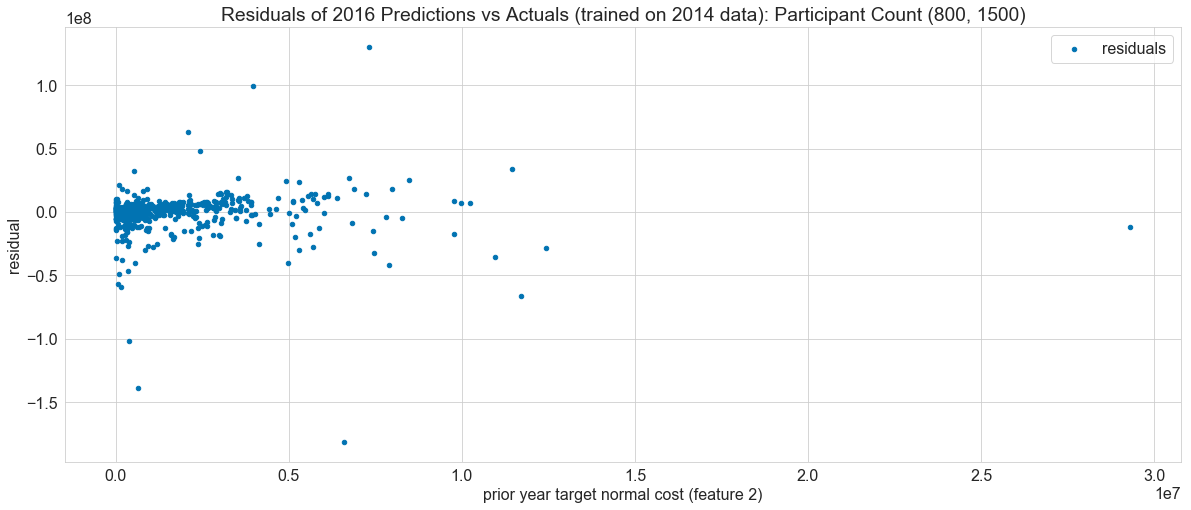

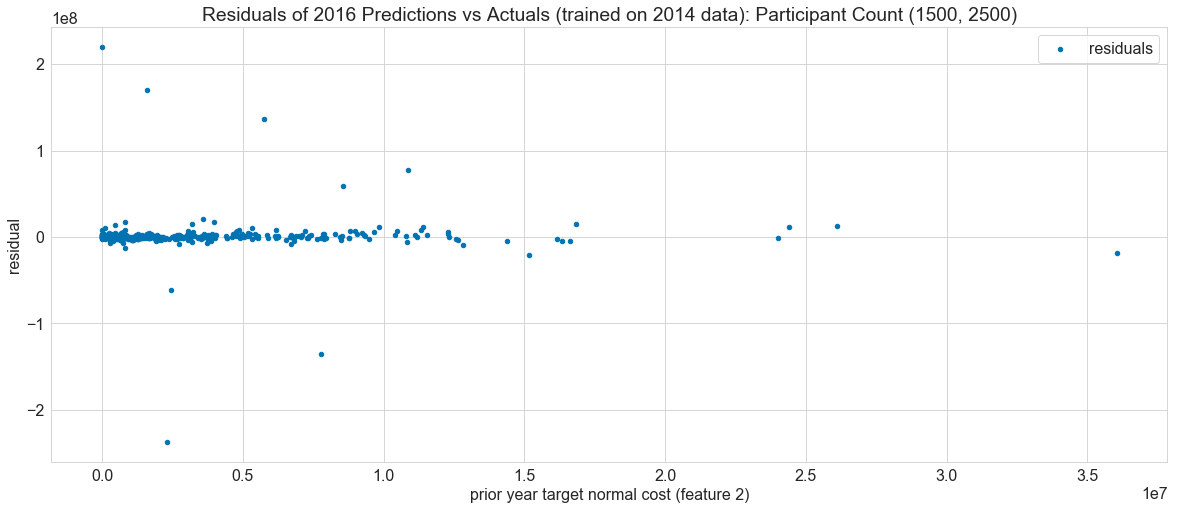

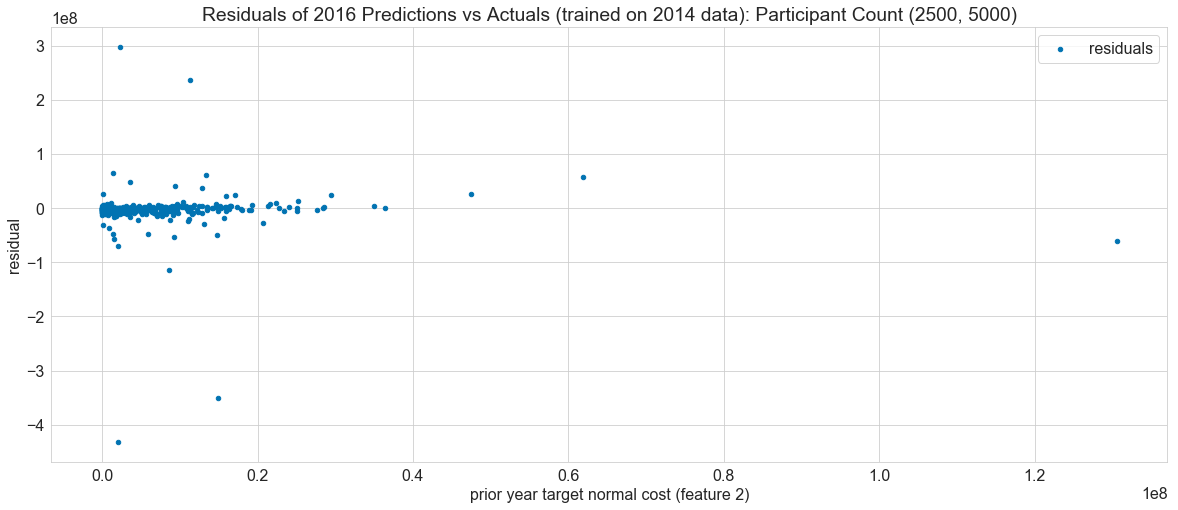

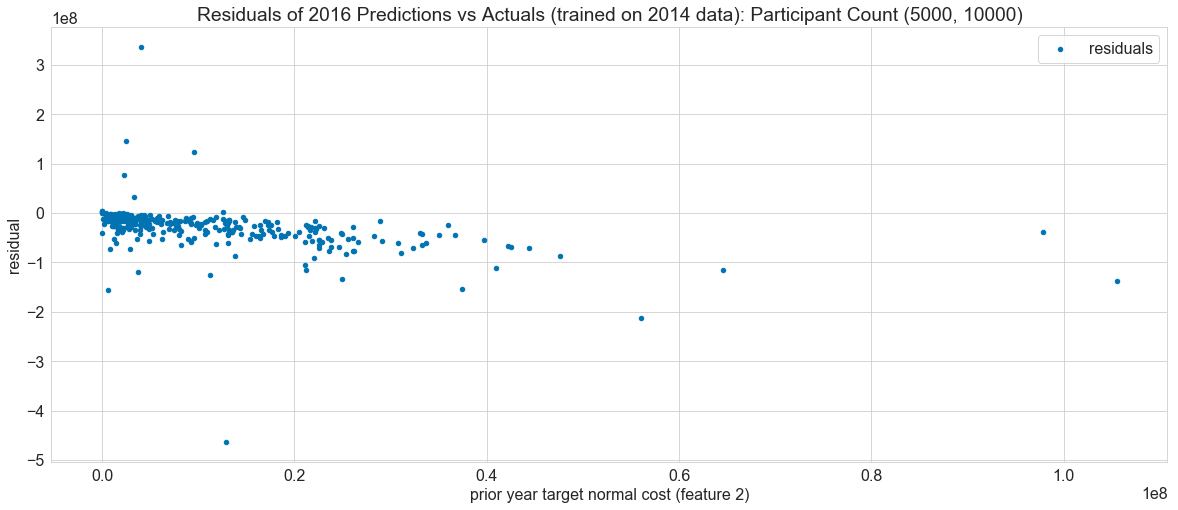

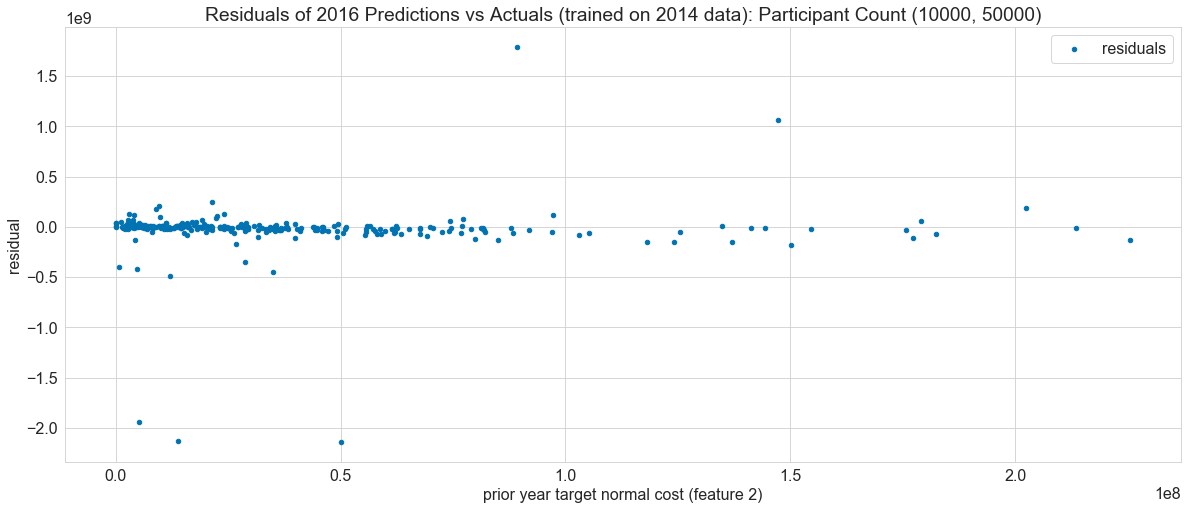

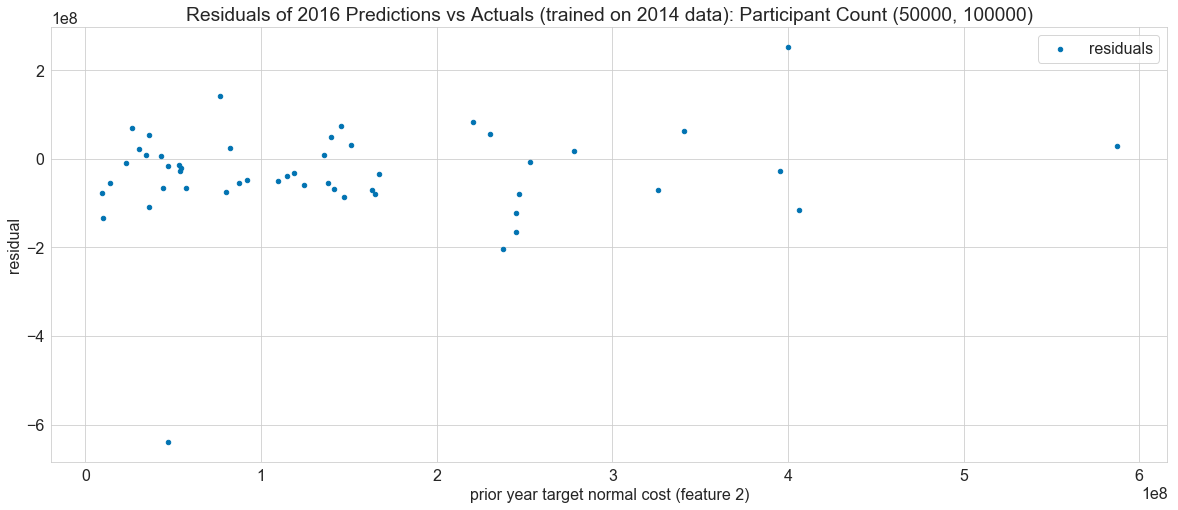

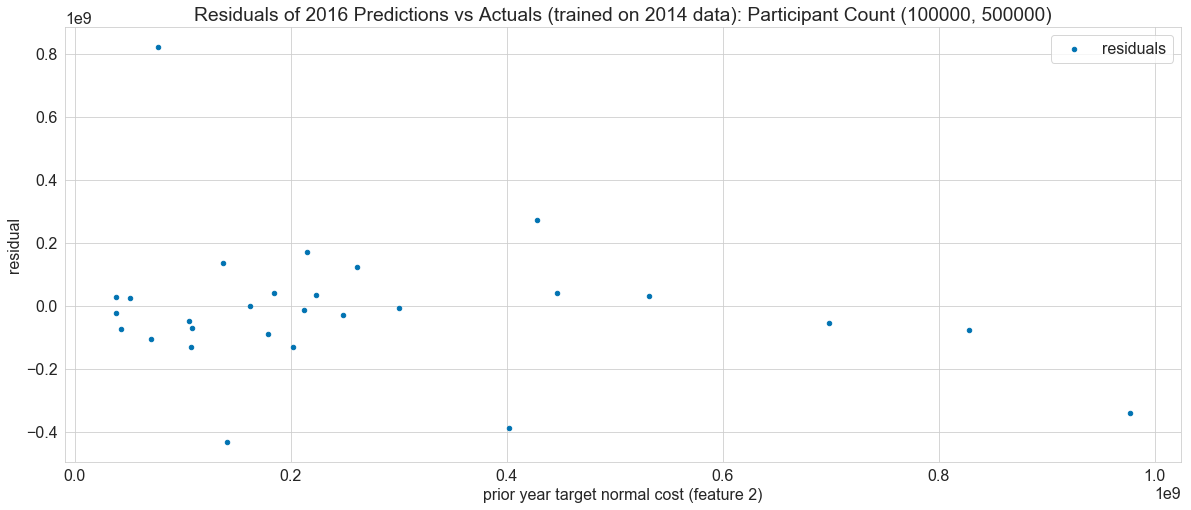

In [60]:
for i in partition_list:
    plt.figure(figsize=(20,8))
    sns.set_palette("colorblind")
    X, y = partitioned_dict_of_df_15[i]
    xx = X['eir_tnc']
    yy = resids_15[i]
    plt.scatter(xx, yy, s=20, label="residuals")
    plt.xlabel("prior year target normal cost (feature 2)")
    plt.ylabel("residual")
    plt.title("Residuals of {} Predictions vs Actuals (trained on {} data): Participant Count {}".format(2016, 2014, i))
    plt.legend()
    plt.show()

<h3>Plot residuals as function of prior year payments</h3>

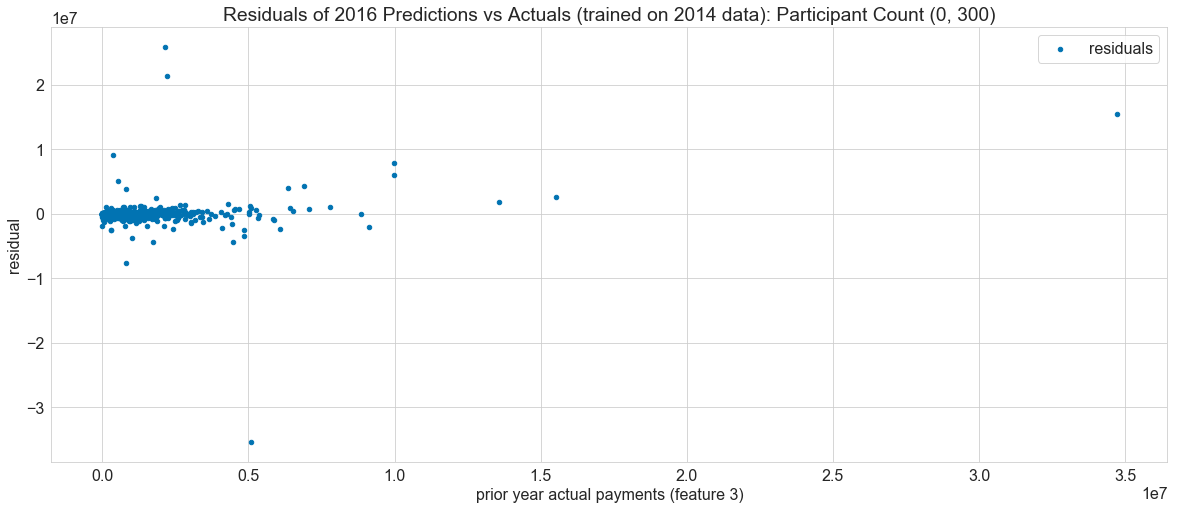

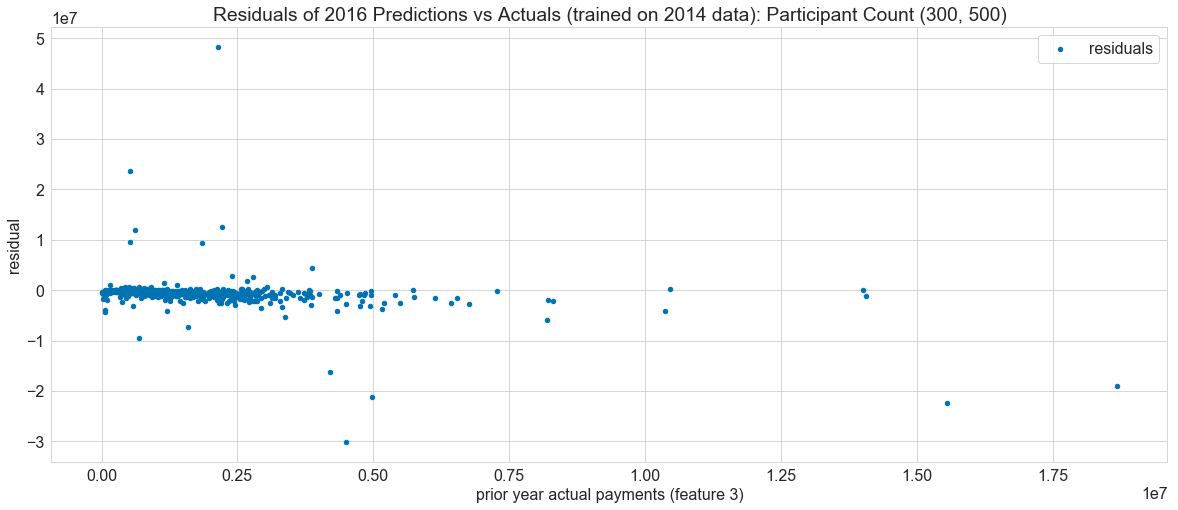

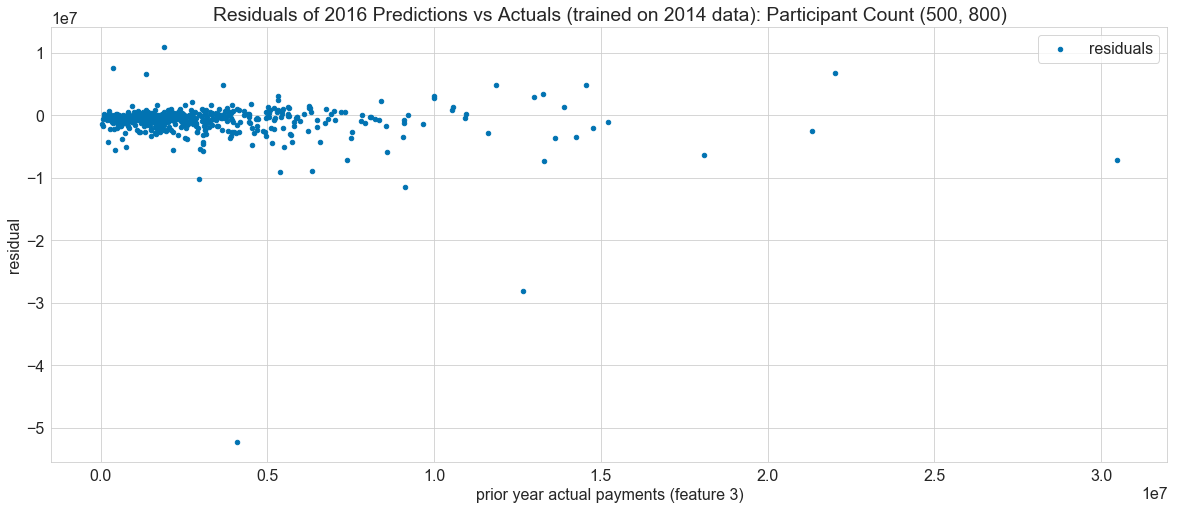

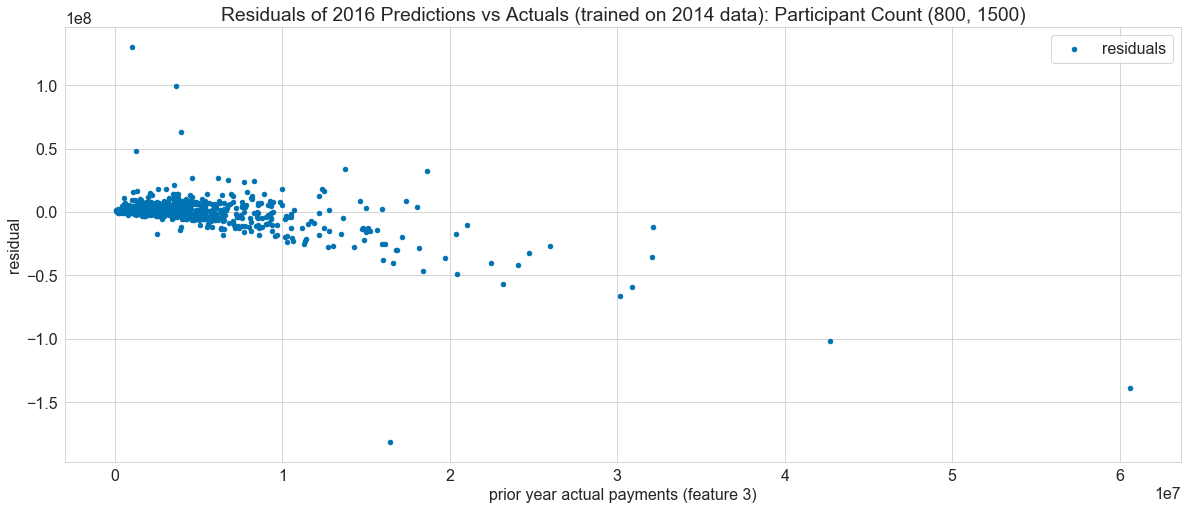

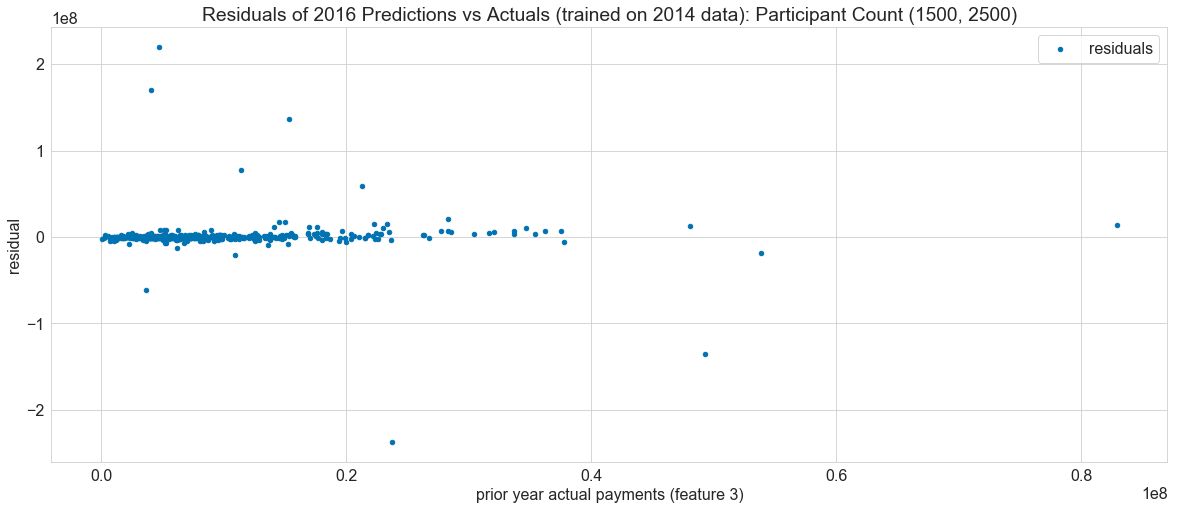

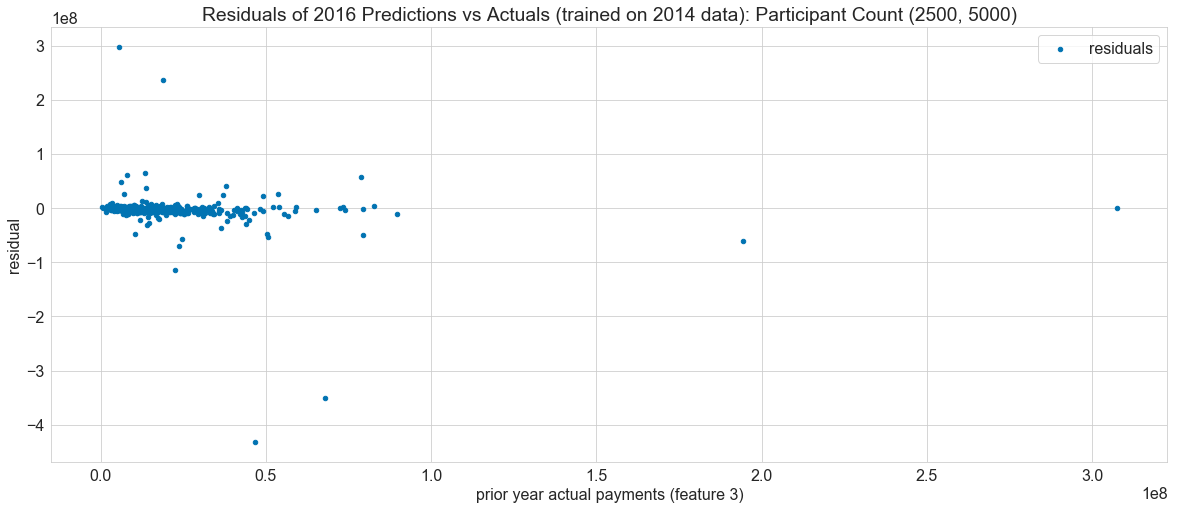

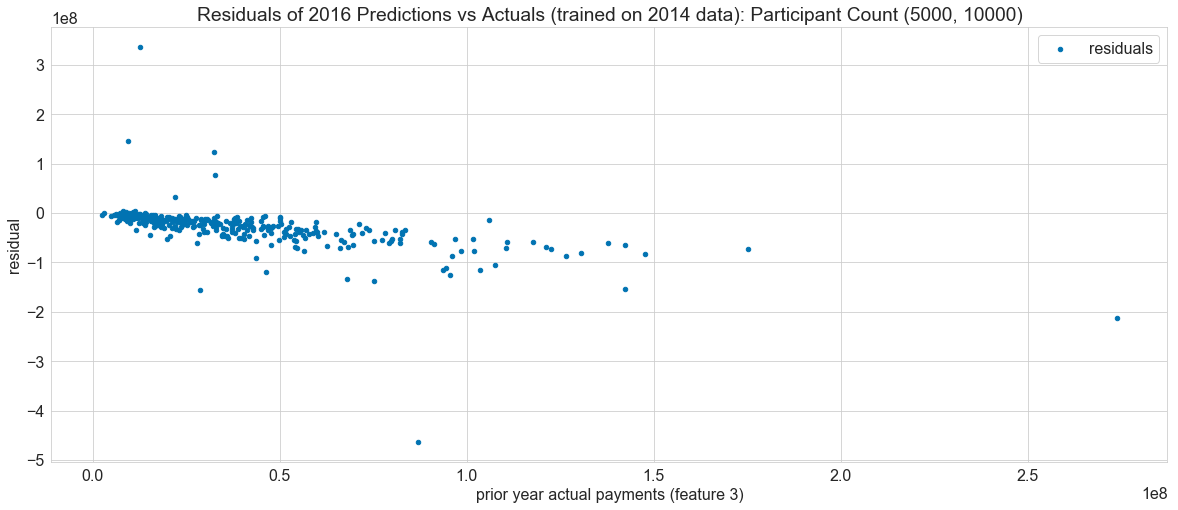

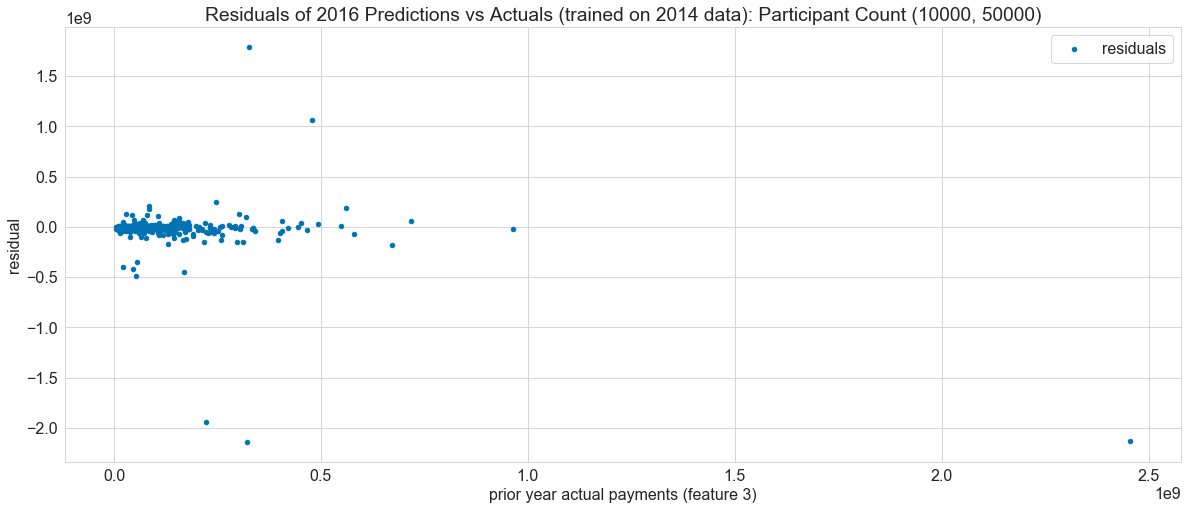

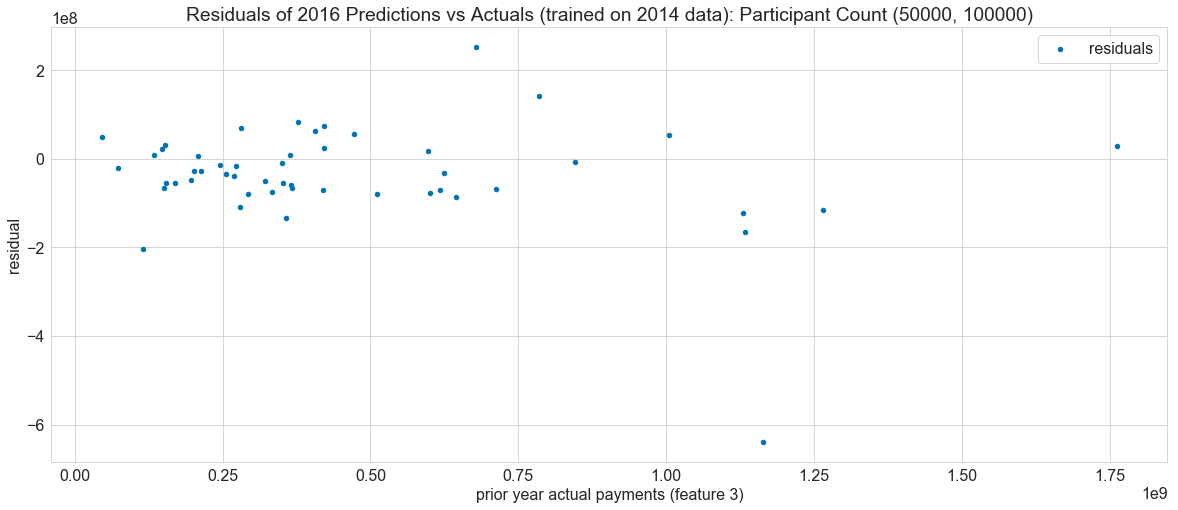

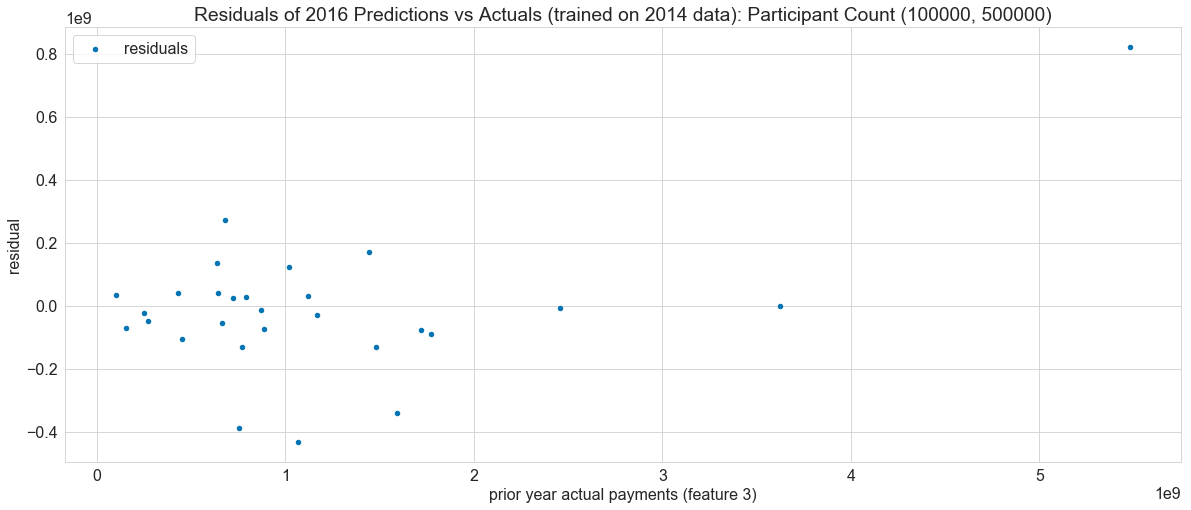

In [61]:
for i in partition_list:
    plt.figure(figsize=(20,8))
    X, y = partitioned_dict_of_df_15[i]
    xx = X['eir_pmt']
    yy = resids_15[i]
    plt.scatter(xx, yy, s=20, label="residuals")
    plt.xlabel("prior year actual payments (feature 3)")
    plt.ylabel("residual")
    plt.title("Residuals of {} Predictions vs Actuals (trained on {} data): Participant Count {}".format(2016, 2014, i))
    plt.legend()
    plt.show()

<b>Distribution of plan sizes</b>

In [ ]:
for i in partition_list:
    print('{} :'.format(i),len(partitioned_dict_of_df_15[i][0]))

Calculate # of plans with 10k+ participants as % of total

In [16]:
np.sum(list(num_plans.values())[7:11])/np.sum(list(num_plans.values()))

0.07587433313574392

In [19]:
total_ft_list = list(total_ft.values())

In [20]:
np.sum(total_ft_list[7:11])/np.sum(total_ft_list)

0.724231116048561

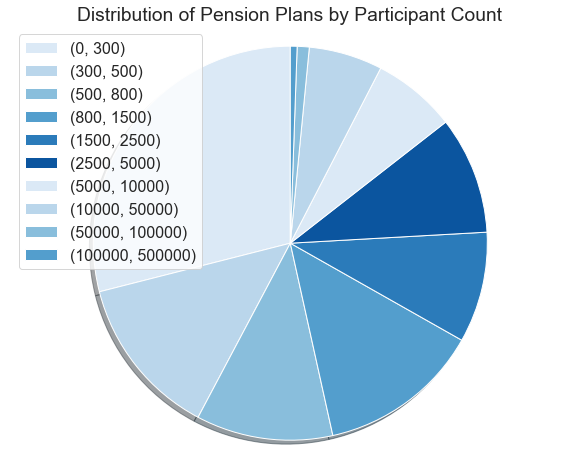

In [43]:
labels = list(partitioned_dict_of_df_15.keys())
sizes = list(num_plans.values())
sns.set_palette("Blues")
plt.figure(figsize=(10,8))
patches, texts = plt.pie(sizes, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.title('Distribution of Pension Plans by Participant Count')
plt.show()

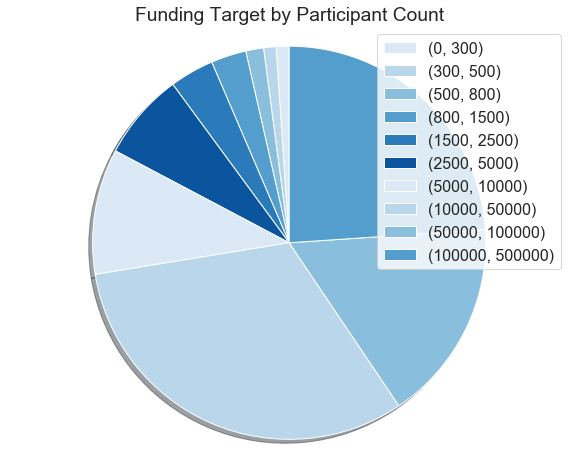

In [45]:
labels = list(partitioned_dict_of_df_15.keys())
sizes = list(total_ft.values())
sns.set_palette("Blues")
plt.figure(figsize=(10,8))
patches, texts = plt.pie(sizes, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.title('Funding Target by Participant Count')
plt.show()

<h3>Model Performance by Participant Count Partition</h3>

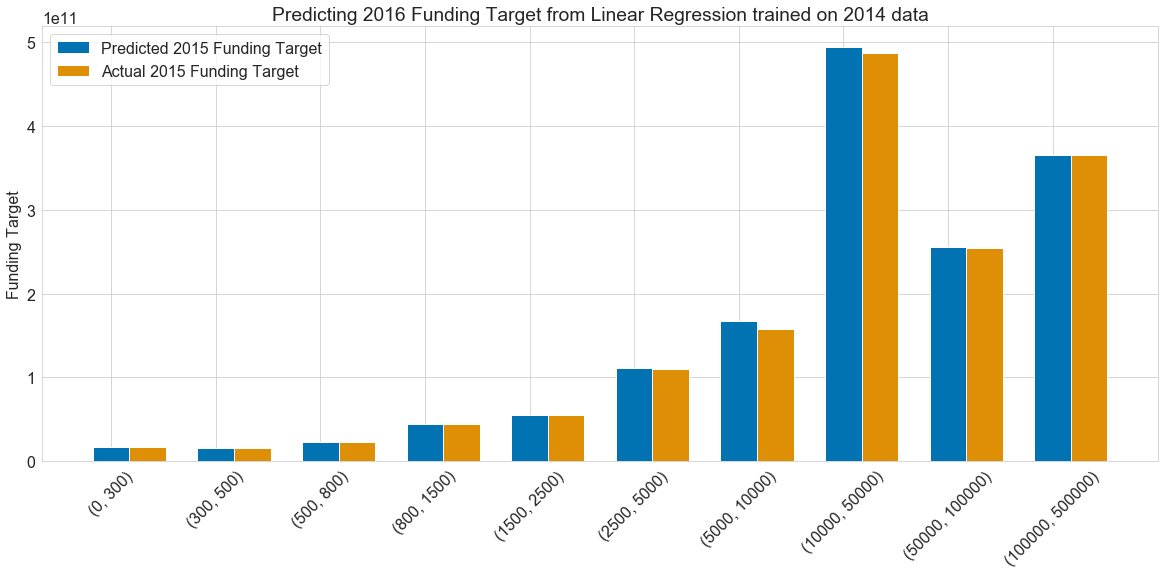

In [36]:
sns.set_palette("colorblind")
xx = np.linspace(0,9,10)
plt.figure(figsize=(20,8))
plt.bar(xx, list(total_pred.values()), label='Predicted {} Funding Target'.format(2015), width=.35 )
plt.bar(xx+.35, list(total_ft.values()), label='Actual {} Funding Target'.format(2015), width=.35)

labels = list(total_pred.keys())
plt.xticks(xx, labels, rotation=45)
plt.ylabel("Funding Target")
plt.title("Predicting {} Funding Target from Linear Regression trained on {} data".format(2016, 2014))
plt.legend()
plt.show()


In [ ]:
for i in partition_list:
    print(len(partitioned_dict_of_df_15[i][0]))

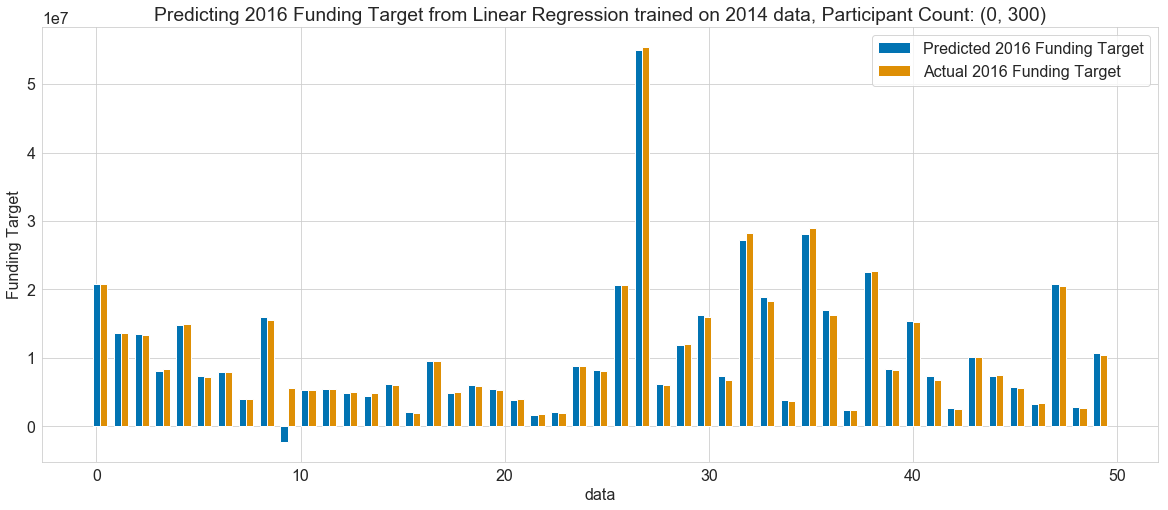

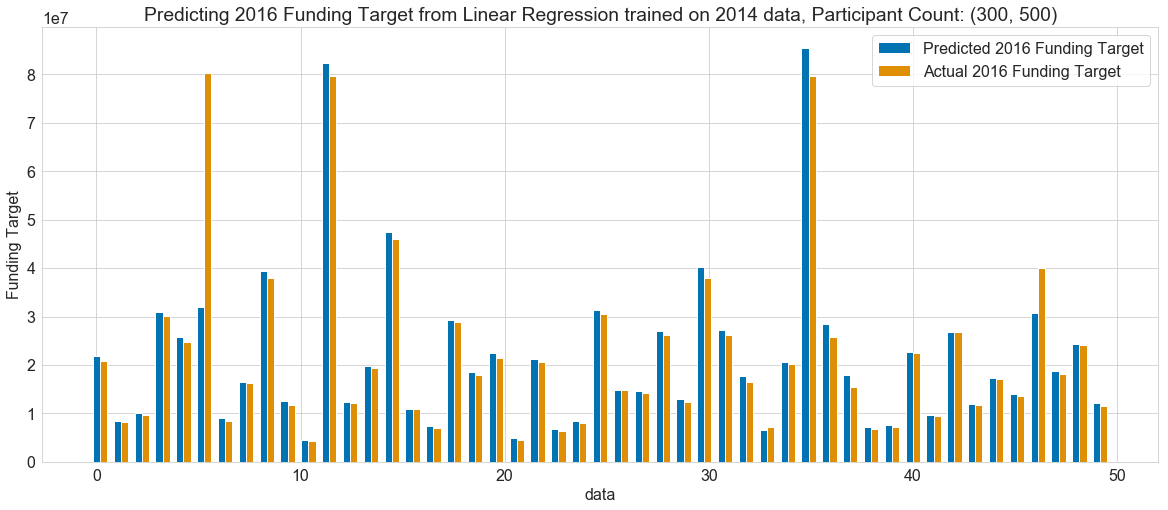

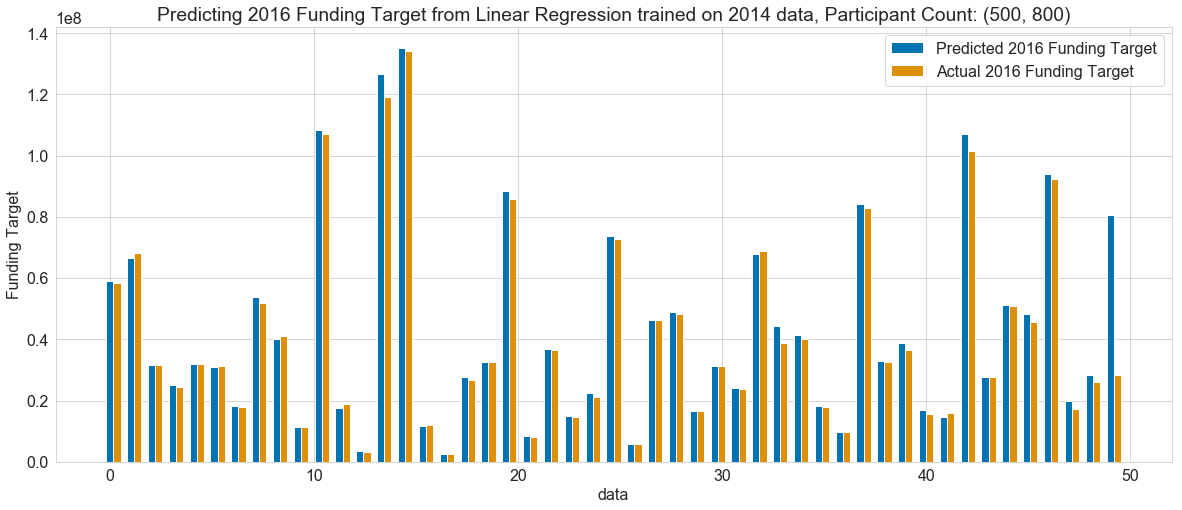

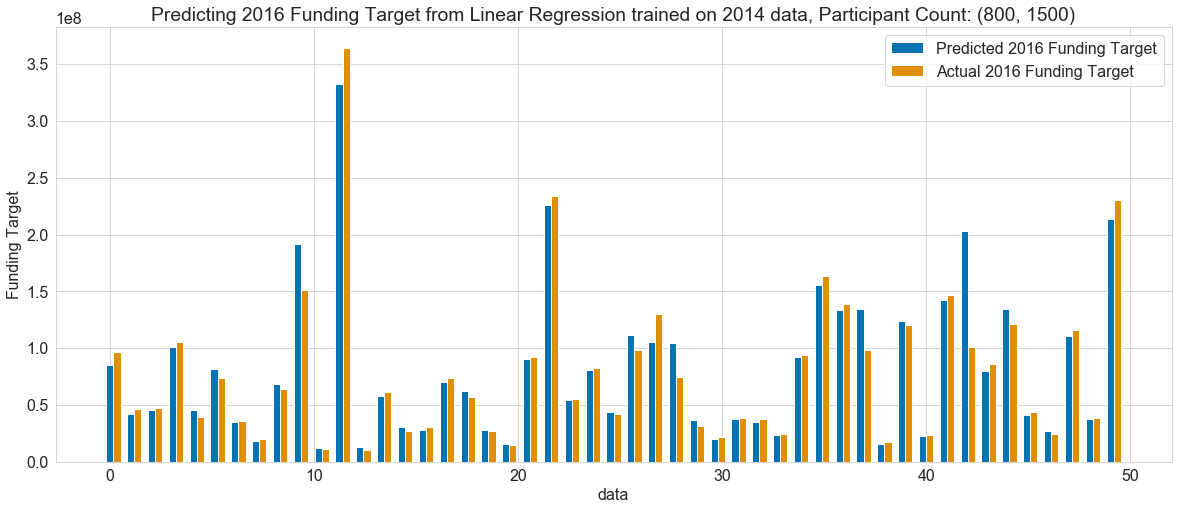

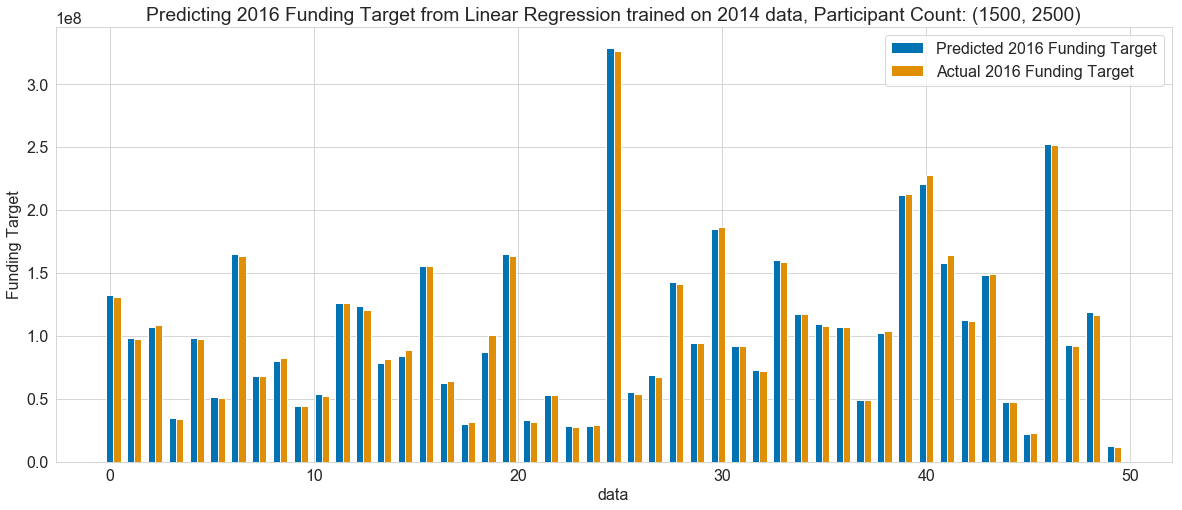

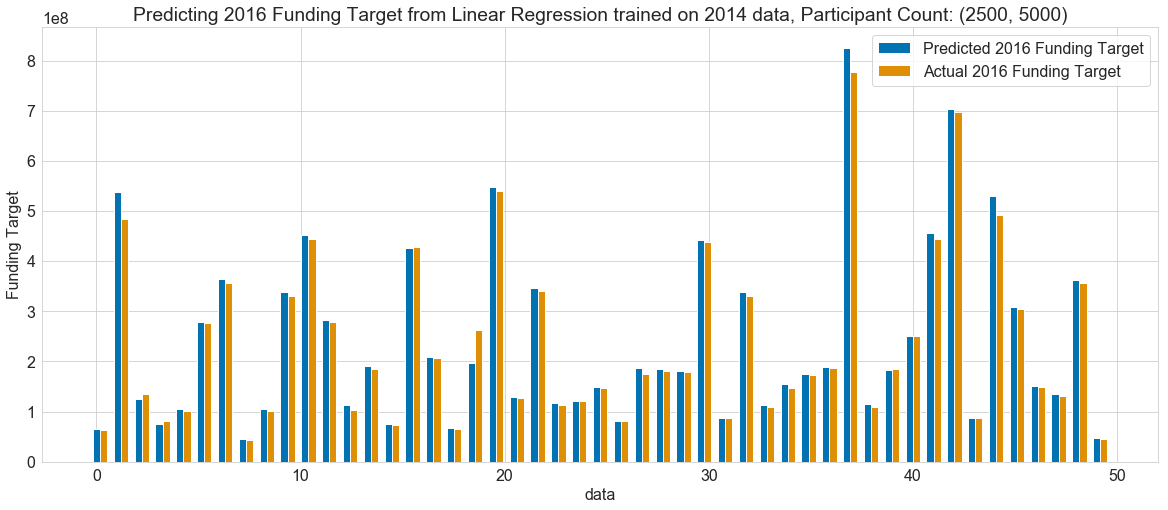

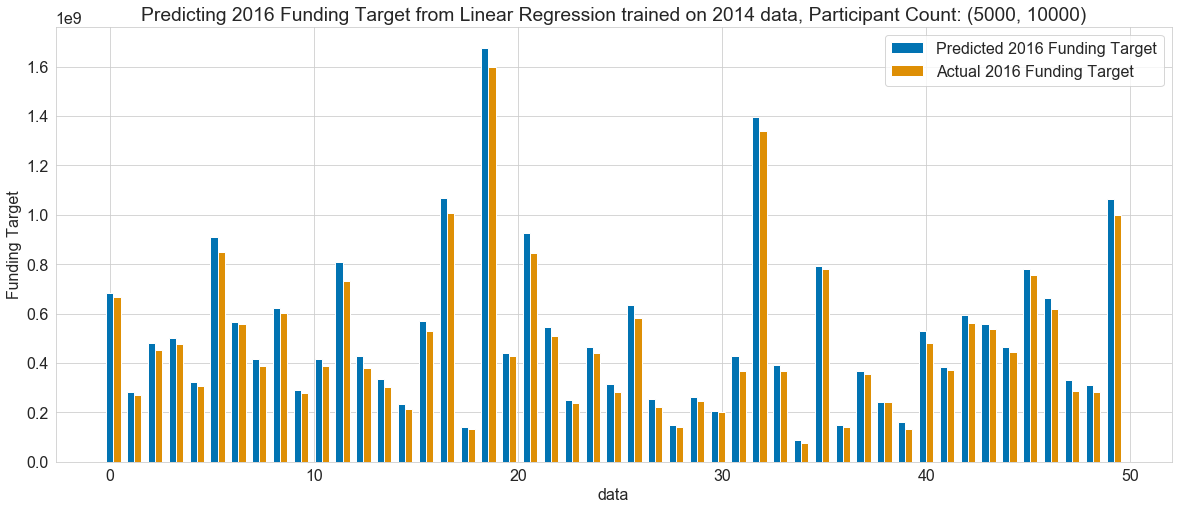

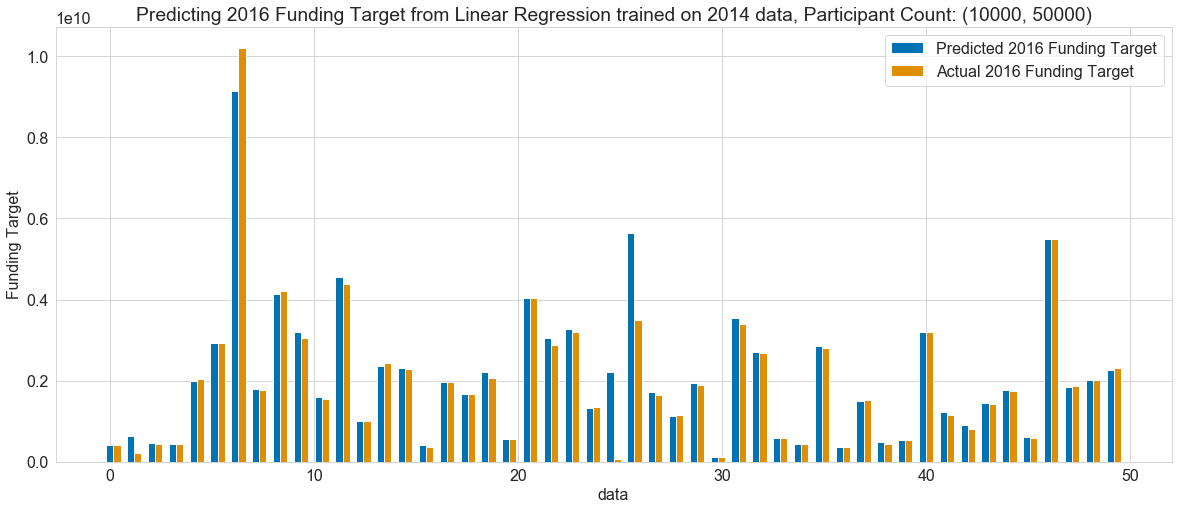

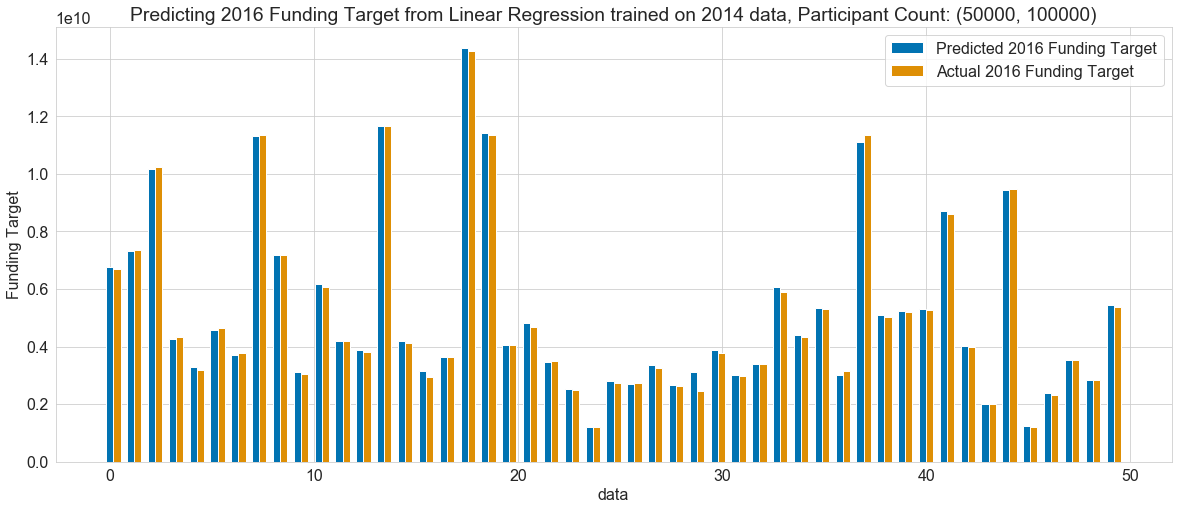

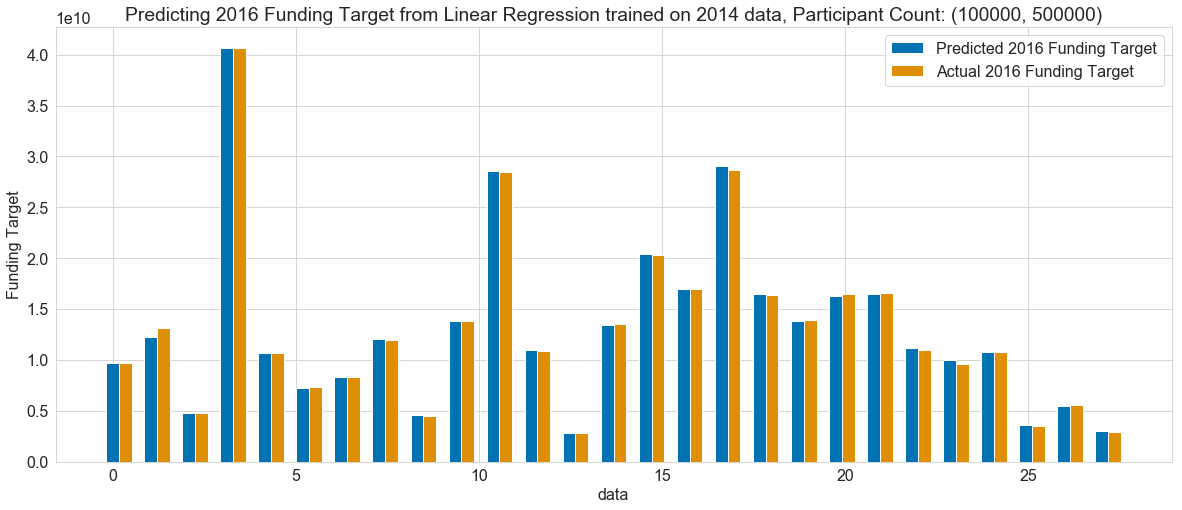

In [37]:
for i in partition_list:
    y_true = partitioned_dict_of_df_15[i][1]
    y_pred = predict_dict_15[i]
    sns.set_palette("colorblind")
    plot_results_bars(y_true, y_pred, i, 0, 50, 2016, 2014)

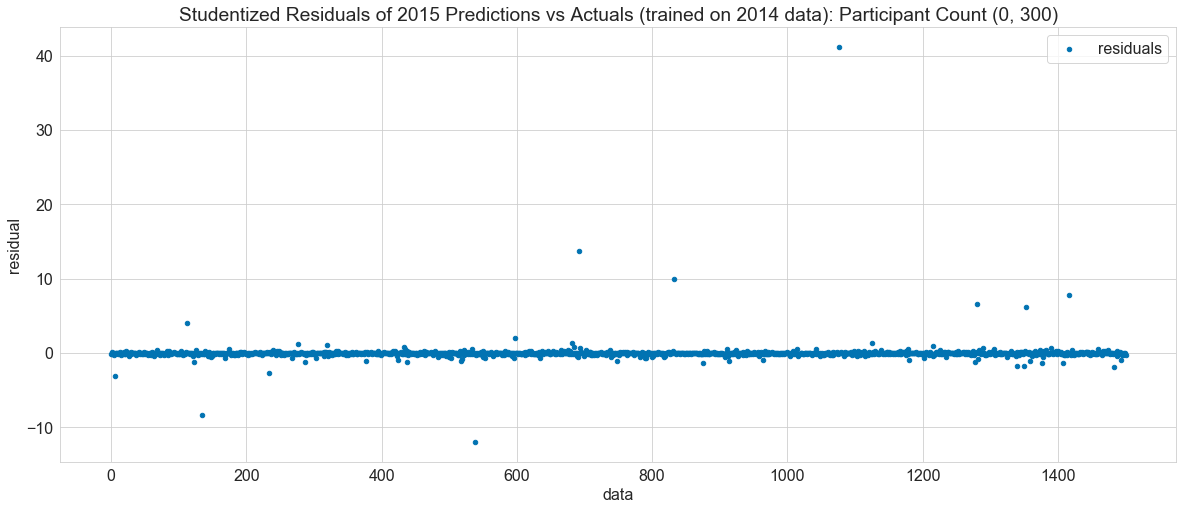

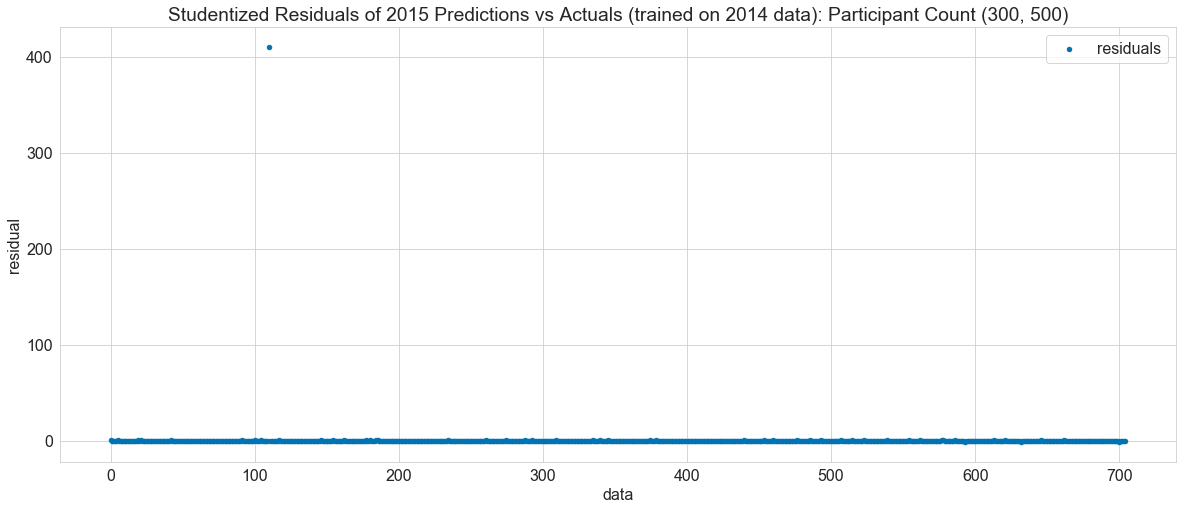

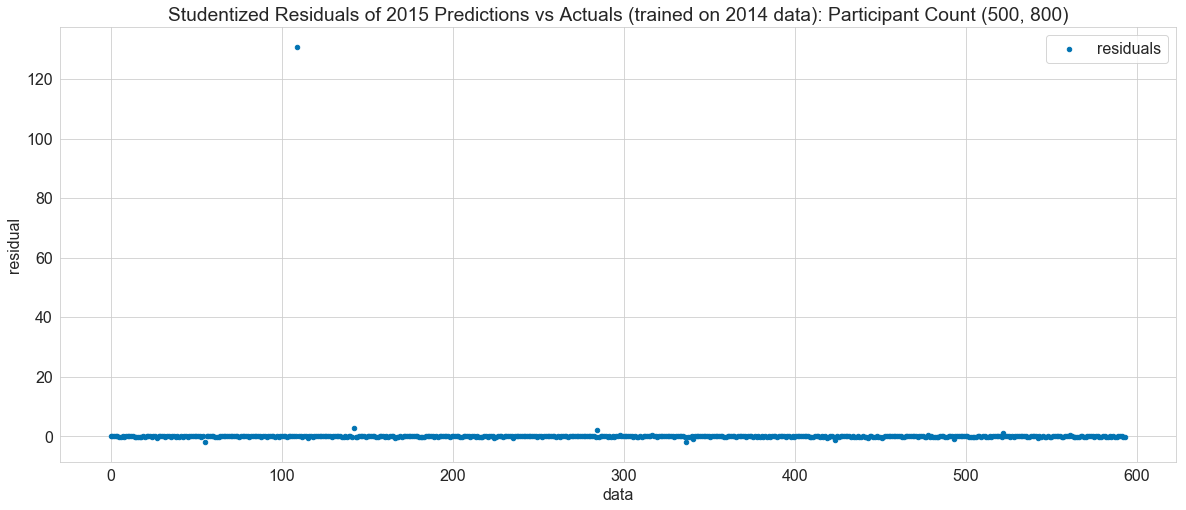

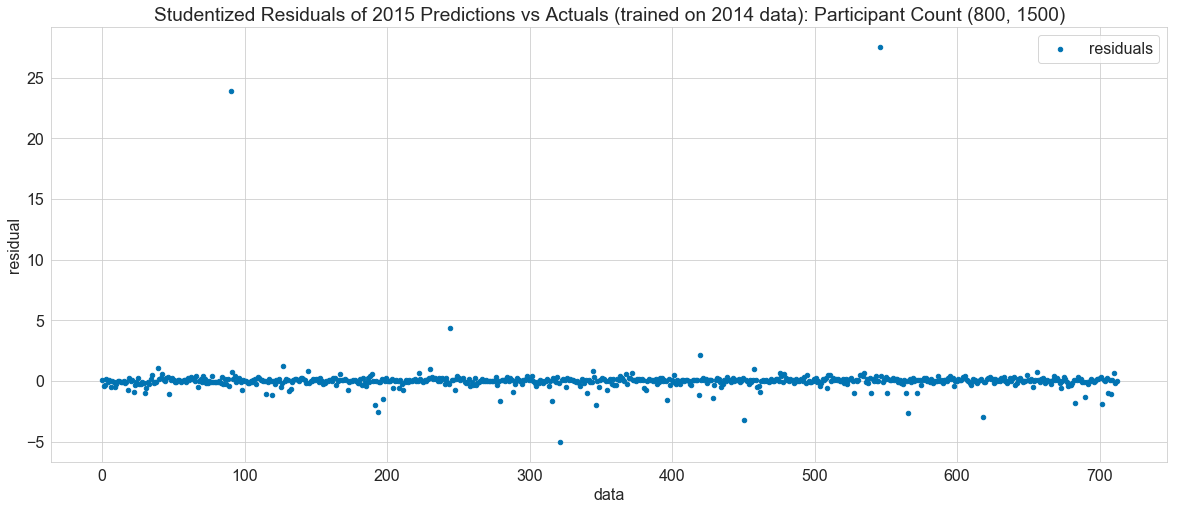

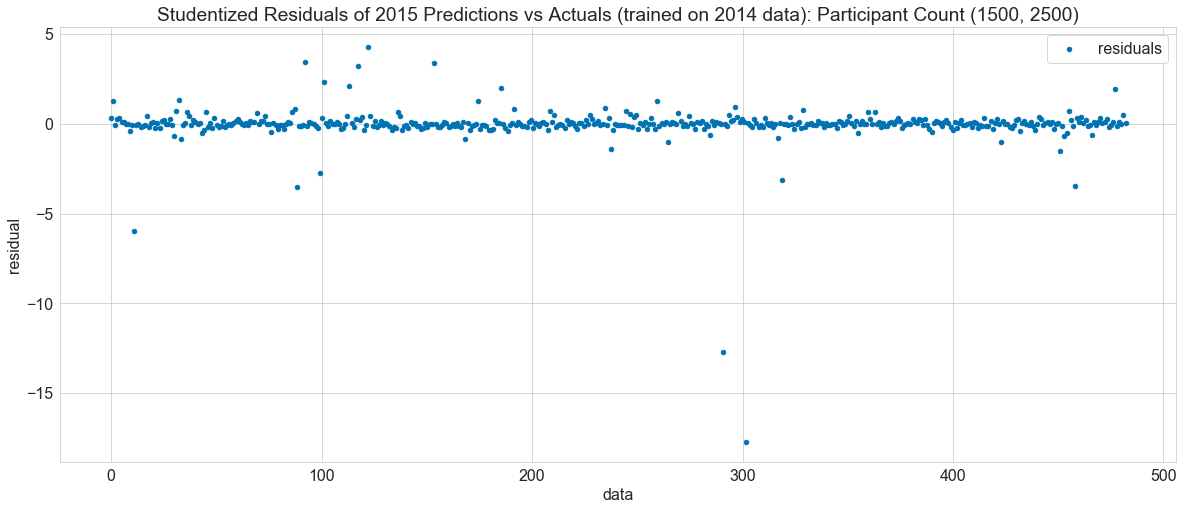

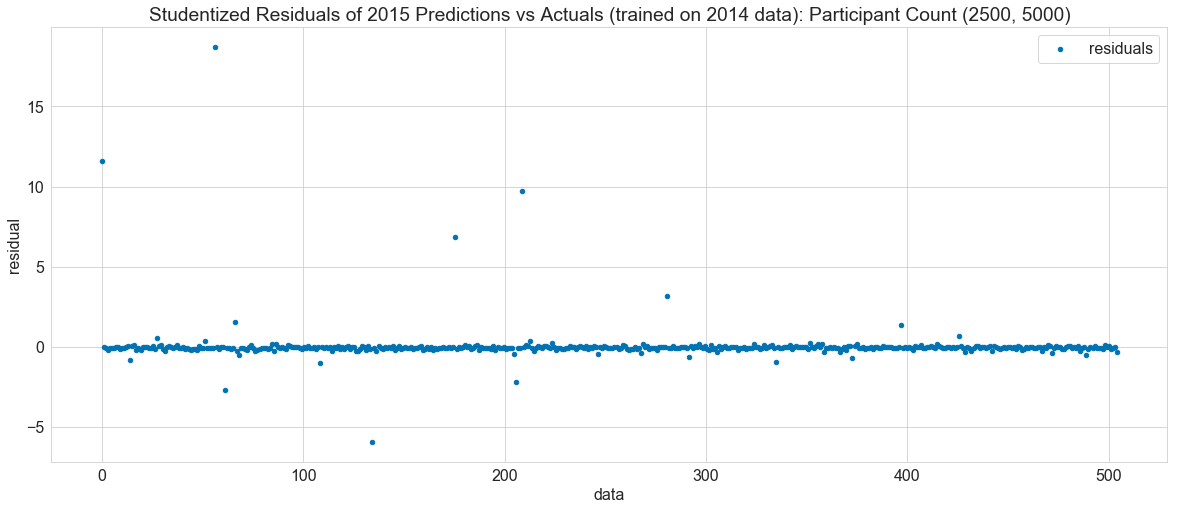

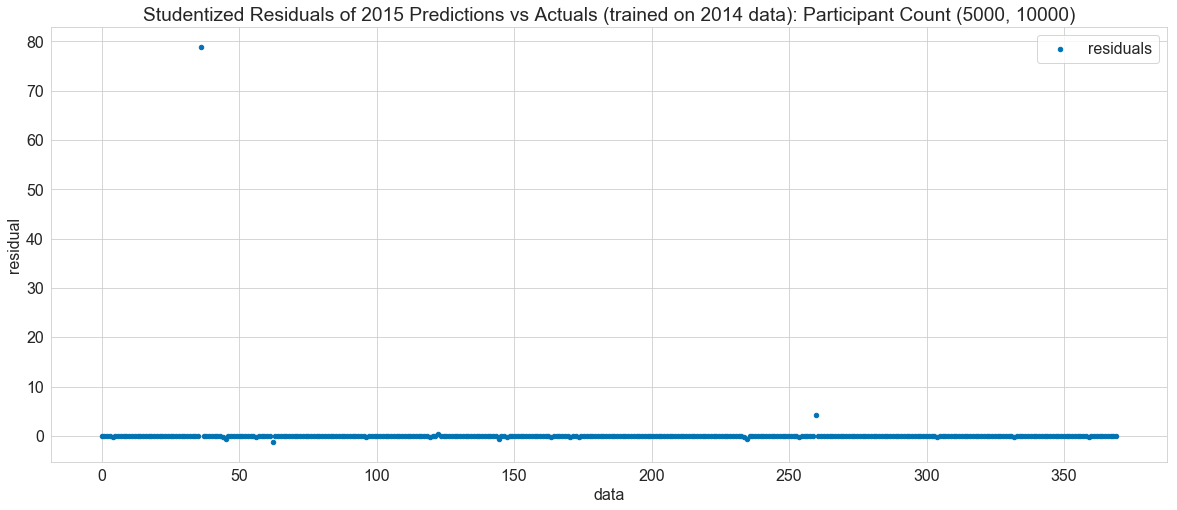

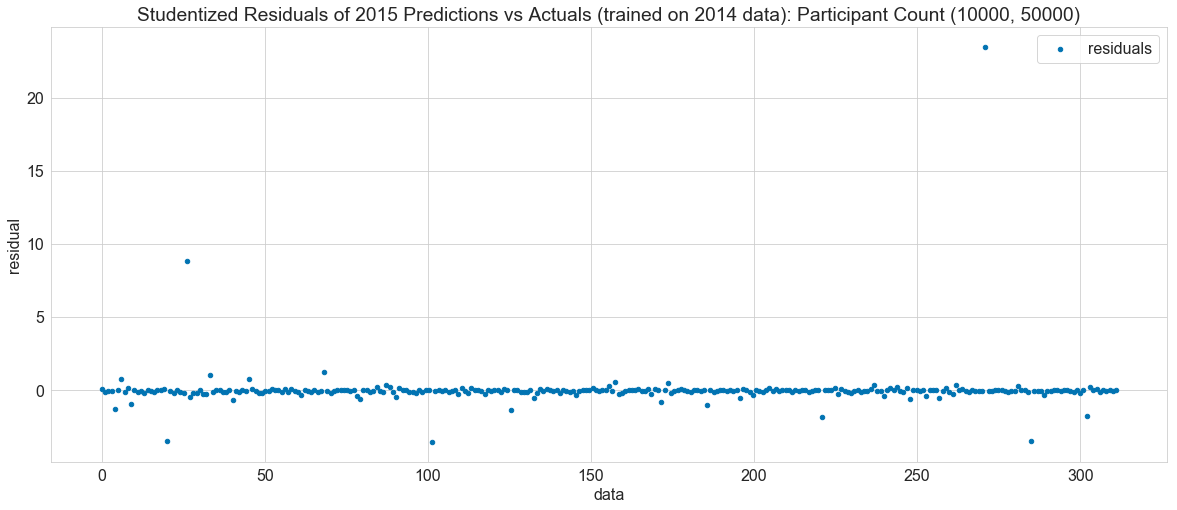

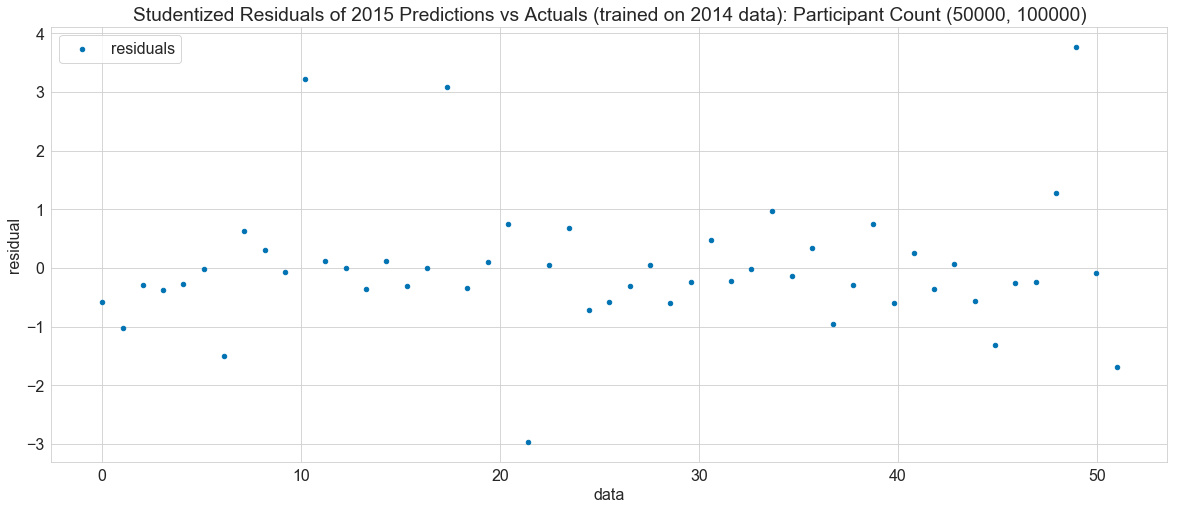

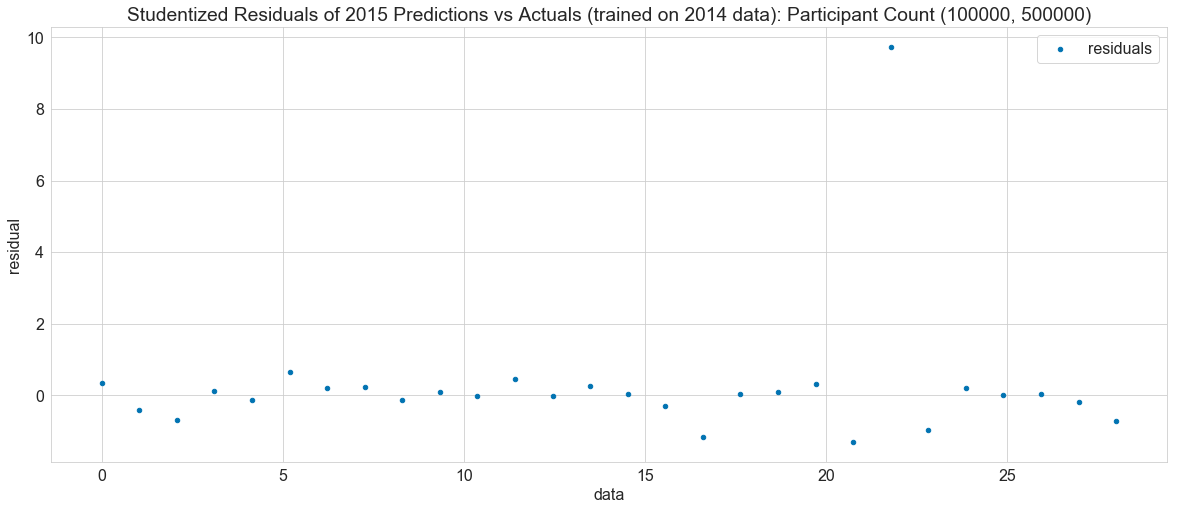

In [51]:
for i in partition_list:
    plot_student_residuals(studentized_resids_15[i]['student_resid'], i, 2015, 2014)

In [66]:
X15 = partition_more_feats_by_ptp_cnt(2015)

In [73]:
X15[(100000, 500000)][0]

eir  part_cnt_2015  fndng_tgt_2015  tgt_nrml_cost_2015  \
0   0.0645         156151      8581938004         656403885.0   
1   0.0641         110107      4515937210         173076035.0   
2   0.0613         126631     15144251203          72370888.0   
3   0.0621         194602     10645498388          35646645.0   
4   0.0622         111917      7093133630         129268796.0   
5   0.0612         294925     40889390622         152684240.0   
6   0.0618         199059      4532481360          66500000.0   
7   0.0626         308649     11958986193          40000000.0   
8   0.0619         264858      8309612643          48000000.0   
9   0.0635         177567      2644145221         102107296.0   
10  0.0627         195072     27032311339         779050106.0   
11  0.0621         180687     13044769985         246518297.0   
12  0.0620         122457     11268568640         101607325.0   
13  0.0627         116636     13425850269         199451346.0   
14  0.0630         155399     16027644812         500054149.0   
15  0.0625         158725     16021805175         233768848.0   
16  0.0636         108728     12893224183         420200302.0   
17  0.0623         181136     20345601386         168212123.0   
18  0.0632         184094     27124621759         918955058.0   
19  0.0620         137371     16272630339         202385631.0   
20  0.0639         181075     15211900435         402341078.0   
21  0.0620         100806      3416366509          99557228.0   
22  0.0627         181544     10778298746         189803460.0   
23  0.0619         308244      9423324304         378224269.0   
24  0.0622         183046      2937910908          35872617.0   
25  0.0653         197313      4952725202         210053850.0   
26  0.0634         123346     11340524692         282205482.0   
27  0.0623         118535     12254392903         133015124.0   

    pmts_to_part_2015        ein   pn  \
0        6.406096e+08  941340523    1   
1        4.163100e+08  131584302    4   
2        5.318195e+09  223408857    1   
3        7.666021e+08  521568099   20   
4        6.193810e+08  221211670    3   
5        3.514220e+09  130871985    1   
6        4.363416e+08  201920798    1   
7        8.579617e+08  560906609    1   
8        7.019384e+08  410449260    1   
9        1.482624e+08  410215170    1   
10       1.666389e+09  521893632    1   
11       9.878431e+08  222640650  201   
12       1.437638e+09  720651161    1   
13       8.423111e+08  800640649   30   
14       1.085906e+09  910425694    1   
15       1.129787e+09   60570975    1   
16       6.226095e+08  370533100    1   
17       1.719877e+09  380549190    1   
18       1.543244e+09  910425694  100   
19       1.398545e+09  510014090    1   
20       6.557741e+08  951732075    1   
21       2.598000e+08  251435979    2   
22       7.439132e+08  130872805    1   
23       7.287046e+08  134994650    1   
24       2.416490e+08  133324058   12   
25       9.520751e+07  951732075   22   
26       2.378777e+09  135315170    1   
27       1.031670e+09  270187394    5   

                                            plan_name  \
0     KAISER PERMANENTE TAX SHELTERED ANNUITY PLAN II   
1            PEPSICO HOURLY EMPLOYEES RETIREMENT PLAN   
2               ALCATEL-LUCENT RETIREMENT INCOME PLAN   
3                              CITIGROUP PENSION PLAN   
4               THE PRUDENTIAL MERGED RETIREMENT PLAN   
5                           IBM PERSONAL PENSION PLAN   
6                         SEARS HOLDINGS PENSION PLAN   
7                    THE BANK OF AMERICA PENSION PLAN   
8             WELLS FARGO & COMPANY CASH BALANCE PLAN   
9                     TARGET CORPORATION PENSION PLAN   
10  LOCKHEED MARTIN CORPORATION SALARIED EMPLOYEE ...   
11  HONEYWELL INTERNATIONAL INC. RETIREMENT EARNIN...   
12                        CENTURYLINK RETIREMENT PLAN   
13                      NORTHROP GRUMMAN PENSION PLAN   
14        THE BOEING COMPANY EMPLOYEE RETIREMENT PLAN   
15  UNITED TECHNOLO